In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import datetime
import time
import math
import glob
import sys
import os

sys.path.append('/kaggle/input/pythonutils')
from Metrics import *

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

import tensorflow as tf 
from keras.layers import Conv1D, Bidirectional, Flatten, Reshape, GRU, Dense, Activation, Dropout, LSTM, MaxPooling1D, Input, Conv1DTranspose, GlobalAveragePooling1D, Attention, LeakyReLU, BatchNormalization, Concatenate
from tensorflow.keras.utils import plot_model
from keras.models import Sequential, load_model, Model 
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau ,EarlyStopping
from keras.optimizers import Adam
from keras.regularizers import l1
from numpy.random import randn, randint

from sklearn.preprocessing import StandardScaler

# Modules

# Preprocessing Data

In [2]:
from Preprocessing import create_house_dataframe, date

dataset_path='/kaggle/input/redd-dataset/REDD-20240715T094421Z-001/REDD'
house_list = [1,2,3,4,5,6]
df = create_house_dataframe(dataset_path , house_list)
dates = date(house_list, df)

House 1 finish:
                     mains_1  mains_2  oven_3  oven_4  refrigerator_5  \
2011-04-18 13:22:13   222.20   118.83     0.0     0.0             6.0   
2011-04-18 13:22:16   223.17   119.19     0.0     0.0             6.0   
2011-04-18 13:22:20   223.60   118.92     0.0     0.0             6.0   
2011-04-18 13:22:23   222.91   119.16     0.0     0.0             6.0   
2011-04-18 13:22:26   222.94   118.83     0.0     0.0             6.0   

                     dishwaser_6  kitchen_outlets_7  kitchen_outlets_8  \
2011-04-18 13:22:13          0.0               34.0               21.0   
2011-04-18 13:22:16          0.0               34.0               21.0   
2011-04-18 13:22:20          0.0               34.0               22.0   
2011-04-18 13:22:23          1.0               35.0               21.0   
2011-04-18 13:22:26          0.0               34.0               21.0   

                     lighting_9  washer_dryer_10  microwave_11  \
2011-04-18 13:22:13        81.0   

In [3]:
house1=df[1].copy()
house2=df[2].copy()
house3=df[3].copy()
house4=df[4].copy()
house5=df[5].copy()
house6=df[6].copy()
houses=[house1,house2,house3,house4,house5,house6]

In [4]:
for house in houses :    
    house['aggregate'] = house['mains_1'] + house['mains_2']
    house.drop(columns = ['mains_1','mains_2'], inplace=True )
    columns = ['aggregate'] + [col for col in house.columns.values[:-1]]
    house = house[columns]
#     print(house)

In [5]:
for i, house in enumerate(houses):
    print(f'House {i+1} --> ', house.columns.values,'\n')

House 1 -->  ['oven_3' 'oven_4' 'refrigerator_5' 'dishwaser_6' 'kitchen_outlets_7'
 'kitchen_outlets_8' 'lighting_9' 'washer_dryer_10' 'microwave_11'
 'bathroom_gfi_12' 'electric_heat_13' 'stove_14' 'kitchen_outlets_15'
 'kitchen_outlets_16' 'lighting_17' 'lighting_18' 'washer_dryer_19'
 'washer_dryer_20' 'aggregate'] 

House 2 -->  ['kitchen_outlets_3' 'lighting_4' 'stove_5' 'microwave_6' 'washer_dryer_7'
 'kitchen_outlets_8' 'refrigerator_9' 'dishwaser_10' 'disposal_11'
 'aggregate'] 

House 3 -->  ['outlets_unknown_3' 'outlets_unknown_4' 'lighting_5' 'electronics_6'
 'refrigerator_7' 'disposal_8' 'dishwaser_9' 'furance_10' 'lighting_11'
 'outlets_unknown_12' 'washer_dryer_13' 'washer_dryer_14' 'lighting_15'
 'microwave_16' 'lighting_17' 'smoke_alarms_18' 'lighting_19'
 'bathroom_gfi_20' 'kitchen_outlets_21' 'kitchen_outlets_22' 'aggregate'] 

House 4 -->  ['lighting_3' 'furance_4' 'kitchen_outlets_5' 'outlets_unknown_6'
 'washer_dryer_7' 'stove_8' 'air_conditioning_9' 'air_condition

### Utils

In [6]:
# This function removes abnormal points
def remove_abnormal_points(y,left_threshold=200,right_threshold=80):
    y_filtered = []
    for i,value in enumerate(y[:-5]):
      
        if i == 0 or i==len(y)-1:
            y_filtered.append(y[i])
        else:
            if y[i]-y[i-1]>left_threshold and y[i]-y[i+5]>right_threshold:
                y_filtered.append(y[i+1]+1)
            else:
                y_filtered.append(y[i])
    return np.array(y_filtered)

def get_differential_sequence(X):      
    X_d = []
    pre_item = 0
    for item in X:
        X_d.append(item-pre_item)
        pre_item = item
    X_d = np.array(X_d)
    return X_d

# Normalization 
def get_odd_data(X_o, y_o, MAX_X, MAX_y):
    
    X_o = remove_abnormal_points(X_o)  
    X_o = X_o/MAX_X 
            
    y_o = remove_abnormal_points(y_o) 
    y_o = y_o/MAX_y 
            
    X = np.expand_dims(X_o,1)  
    y = np.expand_dims(y_o,1) 
            
    return X,y 

def standard_scaler(X,y):
    sc=StandardScaler()
    X = sc.fit_transform(pd.DataFrame(X))
    y = sc.fit_transform(pd.DataFrame(y))
    return X , y 

def shift_segment(X,y,seg_length,stride,print_info=True):
    '''
    X is X_o-X_d-X_dd  shape = (samples,3)
    y is y_o-y_d       shape = (samples,2)
    '''
    X_o_seg = []
    y_o_seg = []
    y_o_seg_average = []
    
      
    for i in range(len(X)-seg_length+1):
        if i%stride==0:
            assert len(X[i:i+seg_length]) == seg_length
            X_o_seg.append(  X[i:i+seg_length].reshape(-1) ) 
#             y_o_seg.append(  y[i:i+seg_length].reshape(-1) )   
            y_o_seg_average.append(  y[i+seg_length//2 -1,0] )
            
    if print_info==True:           
        print(' '*7,'sequence length = {}'.format(len(X)))
        print(' '*7,'windows length = {}'.format(seg_length))
        print(' '*7,'stride = {}'.format(stride))
        print(' '*7,'segments =',len(y_o_seg_average))
    
    return np.array(X_o_seg), np.array(y_o_seg_average)    #, np.array(y_o_seg)   


In [7]:
def search_for_appliance(appliance_name):
    houses={}
    for i in [1,2,3,4,5,6]:
        house=df[i]
        exist = [ appliance for appliance in house.columns.values if appliance.startswith(appliance_name)]
        if exist:
            houses[f"house{i}"]=[appliance for appliance in exist ]
    return houses 

# Fridge

## Prep

In [ ]:
search_for_appliance('refrig')

In [ ]:
# # Only houses that has the refrigerator appliance 
# X1 = df[1]['mains_1'].values.astype(np.float32)
# y1 = df[1]['refrigerator_5'].values.astype(np.float32)
# X2 = df[2]['mains_2'].values.astype(np.float32)
# y2 = df[2]['refrigerator_9'].values.astype(np.float32)
# X3 = df[3]['mains_2'].values.astype(np.float32)
# y3 = df[3]['refrigerator_7'].values.astype(np.float32)
# X5 = df[5]['mains_2'].values.astype(np.float32)
# y5 = df[5]['refrigerator_18'].values.astype(np.float32)
# X6 = df[6]['mains_2'].values.astype(np.float32)
# y6 = df[6]['refrigerator_8'].values.astype(np.float32)

# Only houses that has the refrigerator appliance 
X1 = house1['aggregate'].values.astype(np.float32)
y1 = house1['refrigerator_5'].values.astype(np.float32)
X2 = house2['aggregate'].values.astype(np.float32)
y2 = df[2]['refrigerator_9'].values.astype(np.float32)
X3 = house3['aggregate'].values.astype(np.float32)
y3 = df[3]['refrigerator_7'].values.astype(np.float32)
X5 = house5['aggregate'].values.astype(np.float32)
y5 = df[5]['refrigerator_18'].values.astype(np.float32)
X6 = house6['aggregate'].values.astype(np.float32)
y6 = df[6]['refrigerator_8'].values.astype(np.float32)

In [ ]:
X_list = [X1, X2, X3, X5, X6]  # Aggregated power for each house
y_list = [y1, y2, y3, y5, y6]  # Refrigerator power for each house
fig, axes = plt.subplots(len(X_list), 1, figsize=(20, 15)) 

for i, (X,y)  in enumerate(zip(X_list,y_list)):
    ax = axes[i] 
    ax.plot(X[10000:15000], color=f"C{i}", label=f'House {i+1} - Aggregated Power')
    ax.plot(y[10000:15000], linestyle='--', color=f"C{i+1}", label=f'House {i+1} - Refrigerator Power')
    
    ax.set_title(f'House {i+1} - Aggregated and Refrigerator Power', fontsize=15)
    ax.legend()
    ax.set_xlabel('Time')
    ax.set_ylabel('Power')

plt.tight_layout()
plt.show()

In [ ]:
print('-------- Load Training Data ---------')
first = True
MAX_X = 2000
MAX_y = 200
windows_length = 50
stride = 1

for X,y in [(X1, y1),(X3, y3),(X5, y5),(X6, y6)]:
    
    X_i,y_i = get_odd_data(X, y, MAX_X, MAX_y)
    X_seg_i,y_seg_i = shift_segment(X_i,y_i,windows_length,stride)
    
    print(X_seg_i.shape, y_seg_i.shape)
    
    if first == True:

        X_train = X_i # shape=(samples,3)
        y_train = y_i # shape=(samples,2)
        
        X_o_train_seg = X_seg_i
        y_o_train_seg = y_seg_i

        first = False
    else:
        # shape=(samples+,3)
        X_train = np.vstack((X_train,X_i))
        y_train = np.vstack((y_train,y_i))

        # shape=(samples+,seg_length)
        X_o_train_seg = np.vstack((X_o_train_seg,X_seg_i))
        y_o_train_seg = np.hstack((y_o_train_seg,y_seg_i))

In [ ]:
X_train_seg = X_o_train_seg
y_train_seg = y_o_train_seg

In [ ]:
print('-------- Load Testing Data ---------')
X_i,y_i = get_odd_data(X2, y2, MAX_X, MAX_y)
X_seg_i,y_seg_i = shift_segment(X_i,y_i,windows_length,stride)

X_test = X_i  
y_test = y_i  

X_test_seg = X_seg_i 
y_test_seg = y_seg_i

In [ ]:
print('\nX_train.shape = {}'.format(X_train.shape))
print('y_train.shape = {}'.format(y_train.shape))

print('X_o_train_seg.shape = {}'.format(X_train_seg.shape))
print('y_o_train_seg.shape = {}'.format(y_train_seg.shape))

print('\nX_test.shape = {}'.format(X_test.shape))
print('y_test.shape = {}'.format(y_test.shape))

print('X_o_test_seg.shape = {}'.format(X_test_seg.shape))
print('y_o_test_seg.shape = {}'.format(y_test_seg.shape))

In [ ]:
X_train_seg = np.expand_dims(X_train_seg,axis=2) 
X_test_seg = np.expand_dims(X_test_seg,axis=2) 

print('X_o_train_seg.shape = {}'.format(X_train_seg.shape))
print('y_o_train_seg.shape = {}'.format(y_train_seg.shape))

print('X_o_test_seg.shape = {}'.format(X_test_seg.shape))
print('y_o_test_seg.shape = {}'.format(y_test_seg.shape))

## GRU

In [ ]:
pred= model.predict(X_test_seg)

mse_loss_norm = mse_loss(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y)
mae_loss_norm = mae_loss(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y)
print('Mean square error on test set: ', mse_loss_norm)
print('Mean absolute error on the test set: ', mae_loss_norm)

rpaf = recall_precision_accuracy_f1(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y, 600)
rete = relative_error_total_energy(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y)
mae = mean_absolute_error(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y)

print("============ Recall: {}".format(rpaf[0]))
print("============ Precision: {}".format(rpaf[1]))
print("============ Accuracy: {}".format(rpaf[2]))
print("============ F1 Score: {}".format(rpaf[3]))

print("============ Relative error in total energy: {}".format(rete))
print("============ Mean absolute error(in Watts): {}".format(mae))

In [ ]:
plt.rcParams["figure.figsize"] = [21,9]
plt.plot((pred.reshape(-1)*MAX_y)[10000:30000], color = 'C0', alpha = 0.6, label = 'Predicted value')
plt.plot((y_test_seg*MAX_y)[10000:30000], color = 'C3', alpha = 0.6, label = 'True Value')
plt.legend()


# Light

In [ ]:
search_for_appliance('light')

## Prep

In [ ]:
X1 = house1['aggregate'].values.astype(np.float32)
y10 = house1['lighting_9'].values.astype(np.float32)
y11 = house1['lighting_17'].values.astype(np.float32)
y12 = house1['lighting_18'].values.astype(np.float32)
y1_all=y10+y11+y12

X2 = house2['aggregate'].values.astype(np.float32)
y2 = house2['lighting_4'].values.astype(np.float32)

X3 = house3['aggregate'].values.astype(np.float32)
y30 = house3['lighting_11'].values.astype(np.float32)
y31 = house3['lighting_15'].values.astype(np.float32)
y32 = house3['lighting_17'].values.astype(np.float32)
y33 = house3['lighting_19'].values.astype(np.float32)
y3_all=y30+y31+y32+y33

X4 = house4['aggregate'].values.astype(np.float32)
y40 = house4['lighting_3'].values.astype(np.float32)
y41 = house4['lighting_13'].values.astype(np.float32)
y42 = house4['lighting_18'].values.astype(np.float32)
y43 = house4['lighting_19'].values.astype(np.float32)
y4_all=y40+y41+y42+y43


X5 = house5['aggregate'].values.astype(np.float32)
y50 = house5['lighting_4'].values.astype(np.float32)
y51 = house5['lighting_14'].values.astype(np.float32)
y52 = house5['lighting_17'].values.astype(np.float32)
y53 = house5['lighting_19'].values.astype(np.float32)
y54 = house5['lighting_23'].values.astype(np.float32)
y5_all=y50+y51+y52+y53+y54

# X6 = df[6]['mains_2'].values.astype(np.float32)
# y6 = df[5]['lighting_14'].values.astype(np.float32) ## Low consumption 

In [ ]:
X_list = [X1, X2, X3, X4, X5]  # Aggregated power for each house
y_list = [y1_all, y2, y3_all, y4_all, y5_all]  # lights power for each house
                                        
for i ,(X,y) in enumerate (zip(X_list,y_list)):
    print(f'====== House {i+1} ======')
    print(f'X{i+1}',pd.DataFrame(X).describe())
    print(f'y{i+1}',pd.DataFrame(y).describe(),'\n')

In [ ]:
X=X5
y=y54
plt.rcParams["figure.figsize"] = [20,9]
plt.plot((X), color = 'C0', label = 'Aggregated Power')
plt.plot((y), color = 'C3', label = 'Light Power')
plt.legend()
pd.DataFrame(y).describe()

In [ ]:
fig, axes = plt.subplots(len(X_list), 1, figsize=(20, 15)) 

for i, (X,y)  in enumerate(zip(X_list,y_list)):
    ax = axes[i] 
    ax.plot(X[15000:35000], color=f"C{i}", label=f'House {i+1} - Aggregated Power')
    ax.plot(y[15000:35000], linestyle='--', color=f"C{i+1}", label=f'House {i+1} - Light Power')

    ax.set_title(f'House {i+1} - Aggregated and light Power', fontsize=15)
    ax.legend()
    ax.set_xlabel('Time')
    ax.set_ylabel('Power')

plt.tight_layout()
plt.show()

In [ ]:
print('-------- Load Training Data ---------')
first = True
MAX_X = 2000
MAX_y = 200
windows_length = 50
stride = 1

for X,y in [(X1, y1_all),(X2, y2),(X3, y3_all),(X5, y5_all)]:
    
    X_i,y_i = get_odd_data(X, y, MAX_X, MAX_y)
    X_seg_i,y_seg_i = shift_segment(X_i,y_i,windows_length,stride)
    
    print(X_seg_i.shape, y_seg_i.shape)
    
    if first == True:

        X_train = X_i # shape=(samples,3)
        y_train = y_i # shape=(samples,2)
        
        # shape=(samples,seg_length)
        X_o_train_seg = X_seg_i
        y_o_train_seg = y_seg_i

        first = False
    else:
        # shape=(samples+,3)
        X_train = np.vstack((X_train,X_i))
        y_train = np.vstack((y_train,y_i))

        # shape=(samples+,seg_length)
        X_o_train_seg = np.vstack((X_o_train_seg,X_seg_i))
        y_o_train_seg = np.hstack((y_o_train_seg,y_seg_i))

In [ ]:
X_train_seg = X_o_train_seg
y_train_seg = y_o_train_seg

In [ ]:
print('-------- Load Testing Data ---------')
X_i,y_i = get_odd_data(X4, y4_all, MAX_X, MAX_y)
X_seg_i,y_seg_i = shift_segment(X_i,y_i,windows_length,stride)
X_test = X_i   # shape=(samples,3)
y_test = y_i   # shape=(samples,2)
X_test_seg = X_seg_i 
y_test_seg = y_seg_i

In [ ]:
print('X_train.shape = {}'.format(X_train.shape))
print('y_train.shape = {}'.format(y_train.shape))

print('X_o_train_seg.shape = {}'.format(X_train_seg.shape))
print('y_o_train_seg.shape = {}'.format(y_train_seg.shape))

print('\nX_test.shape = {}'.format(X_test.shape))
print('y_test.shape = {}'.format(y_test.shape))

print('X_o_test_seg.shape = {}'.format(X_test_seg.shape))
print('y_o_test_seg.shape = {}'.format(y_test_seg.shape))

In [ ]:
X_train_seg = np.expand_dims(X_train_seg,axis=2) 
X_test_seg = np.expand_dims(X_test_seg,axis=2) 

print('X_o_train_seg.shape = {}'.format(X_train_seg.shape))
print('y_o_train_seg.shape = {}'.format(y_train_seg.shape))

print('X_o_test_seg.shape = {}'.format(X_test_seg.shape))
print('y_o_test_seg.shape = {}'.format(y_test_seg.shape))

## GRU

In [ ]:
# Load lights model 

In [ ]:
pred= model.predict(X_train_seg)

mse_loss_norm = mse_loss(pred.reshape(-1)*MAX_y, y_train_seg*MAX_y)
mae_loss_norm = mae_loss(pred.reshape(-1)*MAX_y, y_train_seg*MAX_y)
print('Mean square error on test set: ', mse_loss_norm)
print('Mean absolute error on the test set: ', mae_loss_norm)

rpaf = recall_precision_accuracy_f1(pred.reshape(-1)*MAX_y, y_train_seg*MAX_y, 10)
rete = relative_error_total_energy(pred.reshape(-1)*MAX_y, y_train_seg*MAX_y)
mae = mean_absolute_error(pred.reshape(-1)*MAX_y, y_train_seg*MAX_y)

print("============ Recall: {}".format(rpaf[0]))
print("============ Precision: {}".format(rpaf[1]))
print("============ Accuracy: {}".format(rpaf[2]))
print("============ F1 Score: {}".format(rpaf[3]))

print("============ Relative error in total energy: {}".format(rete))
print("============ Mean absolute error(in Watts): {}".format(mae))

In [ ]:
plt.rcParams["figure.figsize"] = [24,10]
plt.plot((pred.reshape(-1)*MAX_y)[50000:80000], color = 'C0',label = 'Predicted value')
plt.plot((y_train_seg*MAX_y)[50000:80000], color = 'C3', label = 'True Value')
plt.legend()
plt.ylabel('Generated Power(kW)', fontsize=20)

# Microwave

In [8]:
search_for_appliance('microwave')

{'house1': ['microwave_11'],
 'house2': ['microwave_6'],
 'house3': ['microwave_16'],
 'house5': ['microwave_3']}

## Prep

In [9]:
X1 = remove_abnormal_points(house1['aggregate'].values.astype(np.float32))
y1 = remove_abnormal_points(house1['microwave_11'].values.astype(np.float32))
X2 = remove_abnormal_points(house2['aggregate'].values.astype(np.float32))
y2 = remove_abnormal_points(house2['microwave_6'].values.astype(np.float32))
X3 = remove_abnormal_points(house3['aggregate'].values.astype(np.float32))
y3 = remove_abnormal_points(house3['microwave_16'].values.astype(np.float32))
# X5 = house5['aggregate'].values.astype(np.float32)
# y5 = house5['microwave_3'].values.astype(np.float32)

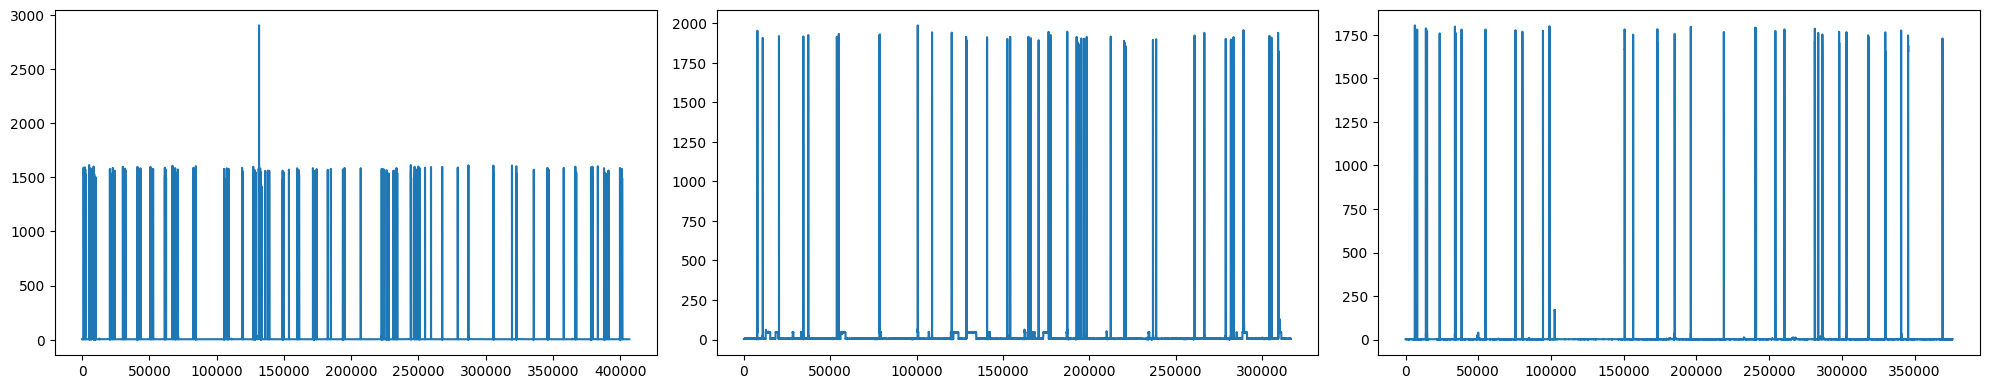

In [10]:
plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
plt.plot(y1)
plt.subplot(1,3,2)
plt.plot(y2)
plt.subplot(1,3,3)
plt.plot(y3)
plt.tight_layout()

In [77]:
pd.DataFrame(house1).describe()

,oven_3,oven_4,refrigerator_5,dishwaser_6,kitchen_outlets_7,kitchen_outlets_8,lighting_9,washer_dryer_10,microwave_11,bathroom_gfi_12,electric_heat_13,stove_14,kitchen_outlets_15,kitchen_outlets_16,lighting_17,lighting_18,washer_dryer_19,washer_dryer_20,aggregate
count,406748.000000,406748.000000,406748.000000,406748.000000,406748.000000,406748.000000,406748.000000,406748.000000,406748.000000,406748.000000,406748.000000,406748.000000,406748.000000,406748.000000,406748.000000,406748.000000,406748.000000,406748.000000,406748.000000
mean,6.206361,7.742122,55.504096,24.917698,21.236535,28.331126,43.300198,3.912454,22.259810,6.998749,0.127590,0.115049,5.501908,2.028563,18.042355,13.307077,0.000080,31.854262,383.496417
std,100.255472,126.784783,89.149730,149.718191,1.958581,16.799793,45.931033,42.428219,164.229323,97.137862,1.073337,0.872150,68.599415,54.460008,29.972681,22.678864,0.029595,291.610783,778.299465
min,0.000000,0.000000,0.000000,0.000000,7.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,90.930000
25%,0.000000,0.000000,6.000000,0.000000,20.000000,21.000000,2.000000,0.000000,4.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,140.157500
50%,0.000000,0.000000,7.000000,0.000000,21.000000,22.000000,42.000000,0.000000,4.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,177.050000
75%,0.000000,0.000000,181.000000,0.000000,22.000000,23.000000,81.000000,0.000000,4.000000,1.000000,0.000000,0.000000,1.000000,0.000000,64.000000,9.000000,0.000000,0.000000,349.240000
max,1725.000000,2565.000000,2359.000000,1422.000000,59.000000,1550.000000,363.000000,4475.000000,2906.000000,1686.000000,192.000000,36.000000,1118.000000,1585.000000,112.000000,90.000000,17.500000,3222.500000,11926.560000


In [11]:
X_list = [X1, X2, X3]  # Aggregated power for each house
y_list = [y1, y2, y3]  # microwave power for each house

for i ,(X,y) in enumerate (zip(X_list,y_list)):
    print(f'====== House {i+1} ======')
    print(f'X{i+1}',pd.DataFrame(X).describe())
    print(f'y{i+1}',pd.DataFrame(y).describe(),'\n')

====== House 1 ======
X1                    0
count  406743.000000
mean      383.015575
std       777.181007
min        90.930000
25%       140.139999
50%       177.050003
75%       349.200012
max     11875.429688
y1                    0
count  406743.000000
mean       22.265219
std       164.287869
min         1.000000
25%         4.000000
50%         4.000000
75%         4.000000
max      2905.000000 

====== House 2 ======
X2                    0
count  316835.000000
mean      230.071433
std       259.048970
min        32.080002
25%        37.880001
50%       262.100006
75%       284.500000
max      3232.979980
y2                    0
count  316835.000000
mean       15.216775
std       109.856527
min         0.000000
25%         4.000000
50%         5.000000
75%         5.000000
max      1986.000000 

====== House 3 ======
X3                    0
count  376145.000000
mean      444.605156
std       730.186236
min         1.400000
25%       142.429993
50%       252.130005
75%       45

In [12]:
X_all=[]
y_all=[]
for (X,y) in zip(X_list,y_list) : 
#     print(np.shape(y))
    X_all=np.concatenate((X_all,X))
    y_all=np.concatenate((y_all,y))
# print(np.shape(y_all))

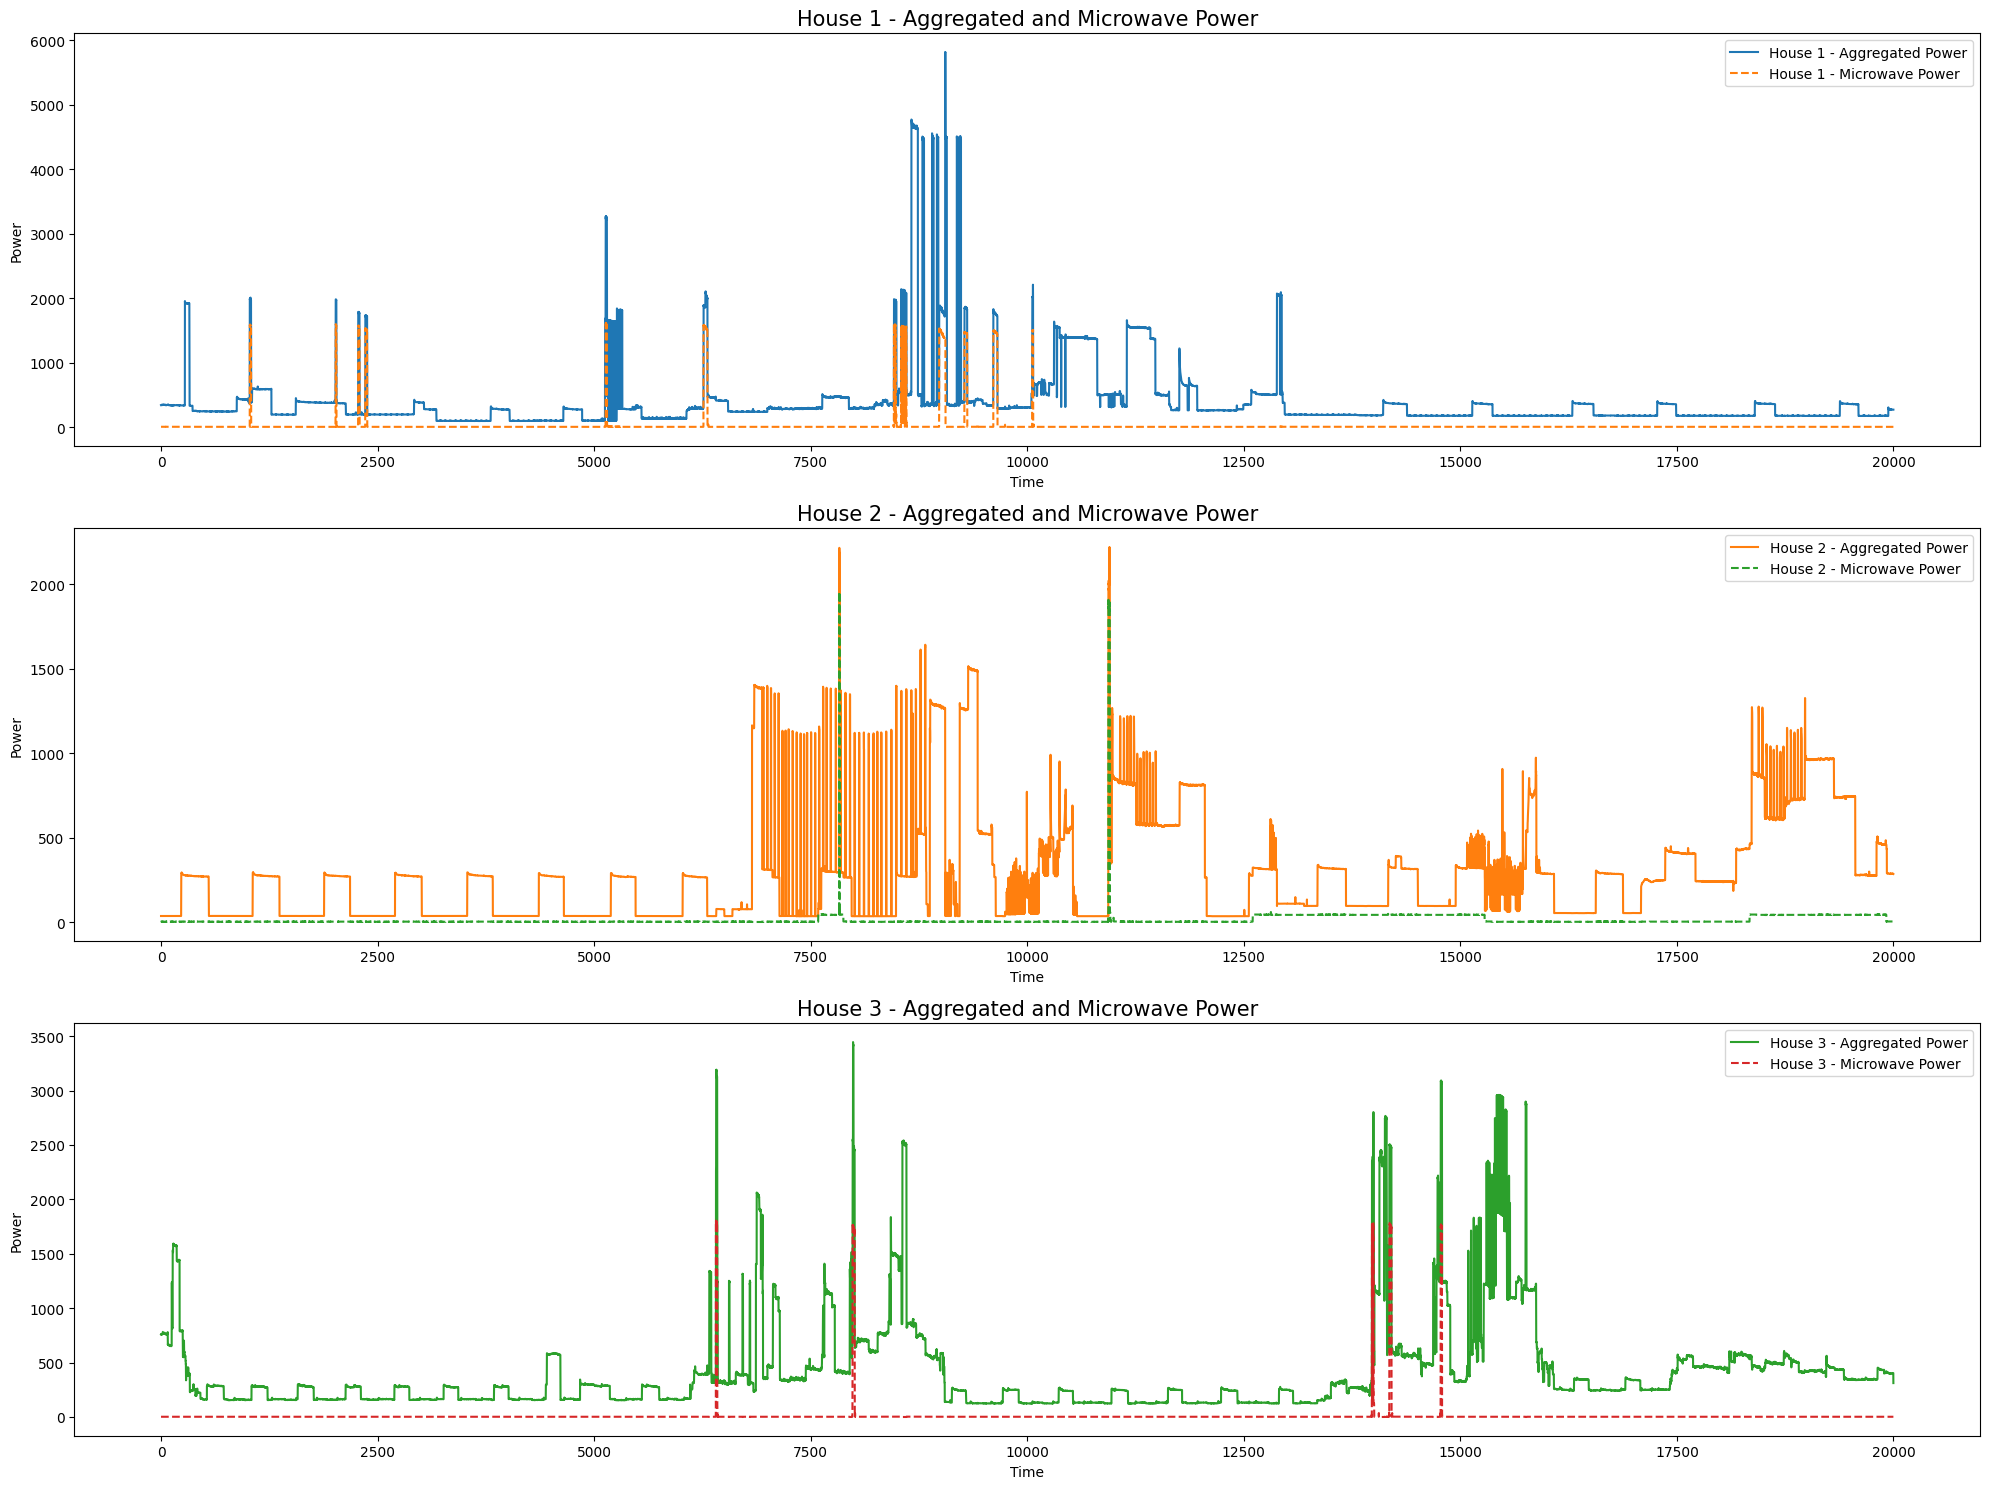

In [13]:
fig, axes = plt.subplots(len(X_list), 1, figsize=(20, 15)) 

for i, (X,y)  in enumerate(zip(X_list,y_list)):
    ax = axes[i] 
    ax.plot(X[:20000], color=f"C{i}", label=f'House {i+1} - Aggregated Power')
    ax.plot(y[:20000], linestyle='--', color=f"C{i+1}", label=f'House {i+1} - Microwave Power')

    ax.set_title(f'House {i+1} - Aggregated and Microwave Power', fontsize=15)
    ax.legend()
    ax.set_xlabel('Time')
    ax.set_ylabel('Power')

plt.tight_layout()
plt.show()

In [14]:
print('-------- Load Training Data ---------')
first = True
MAX_X = 3000
MAX_y = 2000
windows_length = 100
stride = 1      

for X,y in [(X1, y1),(X2, y2),(X3, y3)]:
    
    X_i, y_i = get_odd_data(X, y, MAX_X, MAX_y)
    X_seg_i, y_seg_i   = shift_segment(X_i,y_i,windows_length,stride)
    
    print(X_seg_i.shape, y_seg_i.shape)
    
    if first == True:

        X_train = X_i 
        y_train = y_i 
        
        X_o_train_seg = X_seg_i
        y_o_train_seg = y_seg_i
        first = False
    else:

        X_train = np.vstack((X_train,X_i))
        y_train = np.vstack((y_train,y_i))

        X_o_train_seg = np.vstack((X_o_train_seg,X_seg_i))
        y_o_train_seg = np.hstack((y_o_train_seg,y_seg_i))

        
X_train_seg = X_o_train_seg
y_train_seg = y_o_train_seg

-------- Load Training Data ---------
        sequence length = 406738
        windows length = 100
        stride = 1
        segments = 406639
(406639, 100) (406639,)
        sequence length = 316830
        windows length = 100
        stride = 1
        segments = 316731
(316731, 100) (316731,)
        sequence length = 376140
        windows length = 100
        stride = 1
        segments = 376041
(376041, 100) (376041,)


In [15]:
test_size=len(X_train_seg)//5
print(test_size)
X_train_segm , X_test_segm = X_train_seg[:-test_size] , X_train_seg[-test_size:]
y_train_segm , y_test_segm = y_train_seg[:-test_size] , y_train_seg[-test_size:]
print('X_train_seg shape = {}'.format(X_train_segm.shape))
print('y_train_seg shape = {}'.format(y_train_segm.shape))
print('X_test_seg shape = {}'.format(X_test_segm.shape))
print('y_test_seg shape = {}'.format(y_test_segm.shape))

219882
X_train_seg shape = (879529, 100)
y_train_seg shape = (879529,)
X_test_seg shape = (219882, 100)
y_test_seg shape = (219882,)


## GRU

In [48]:
def r_squared(y_predict, y):
    ss_total = np.sum((y - np.mean(y)) ** 2)
    ss_residual = np.sum((y - y_predict) ** 2)
    return 1 - (ss_residual / ss_total)

### With Data Augmentation

In [60]:
aug_model=load_model("/kaggle/working/best_GRU_microwave_aug.keras")

pred= aug_model.predict(X_test_segm)

mse_loss_norm = mse_loss(pred.reshape(-1)*MAX_y, y_test_segm*MAX_y)
mae_loss_norm = mae_loss(pred.reshape(-1)*MAX_y, y_test_segm*MAX_y)

rpaf = recall_precision_accuracy_f1(pred.reshape(-1)*MAX_y, y_test_segm*MAX_y, 400)
rete = relative_error_total_energy(pred.reshape(-1)*MAX_y, y_test_segm*MAX_y)
mae = mean_absolute_error(pred.reshape(-1)*MAX_y, y_test_segm*MAX_y)
r2 = r_squared(pred.reshape(-1)*MAX_y, y_test_segm*MAX_y)

print("============ Recall: {}".format(rpaf[0]))
print("============ Precision: {}".format(rpaf[1]))
print("============ Accuracy: {}".format(rpaf[2]))
print("============ F1 Score: {}".format(rpaf[3]))
print("============ R-squared:", r2)

print("============ Mean square error: ", mse_loss_norm)
print("============ Relative error in total energy: {}".format(rete))
print("============ Mean absolute error(in Watts): {}".format(mae))

6872/6872 ━━━━━━━━━━━━━━━━━━━━ 45s 6ms/step
============ Recall: 0.9967497291440953
============ Precision: 0.959332638164755
============ Accuracy: 0.9998089884574454
============ F1 Score: 0.9776833156216791
============ R-squared: 0.9770675809810828
============ Mean square error:  277.91746398200036
============ Relative error in total energy: 0.24348216584999094
============ Mean absolute error(in Watts): 3.9609815015064145


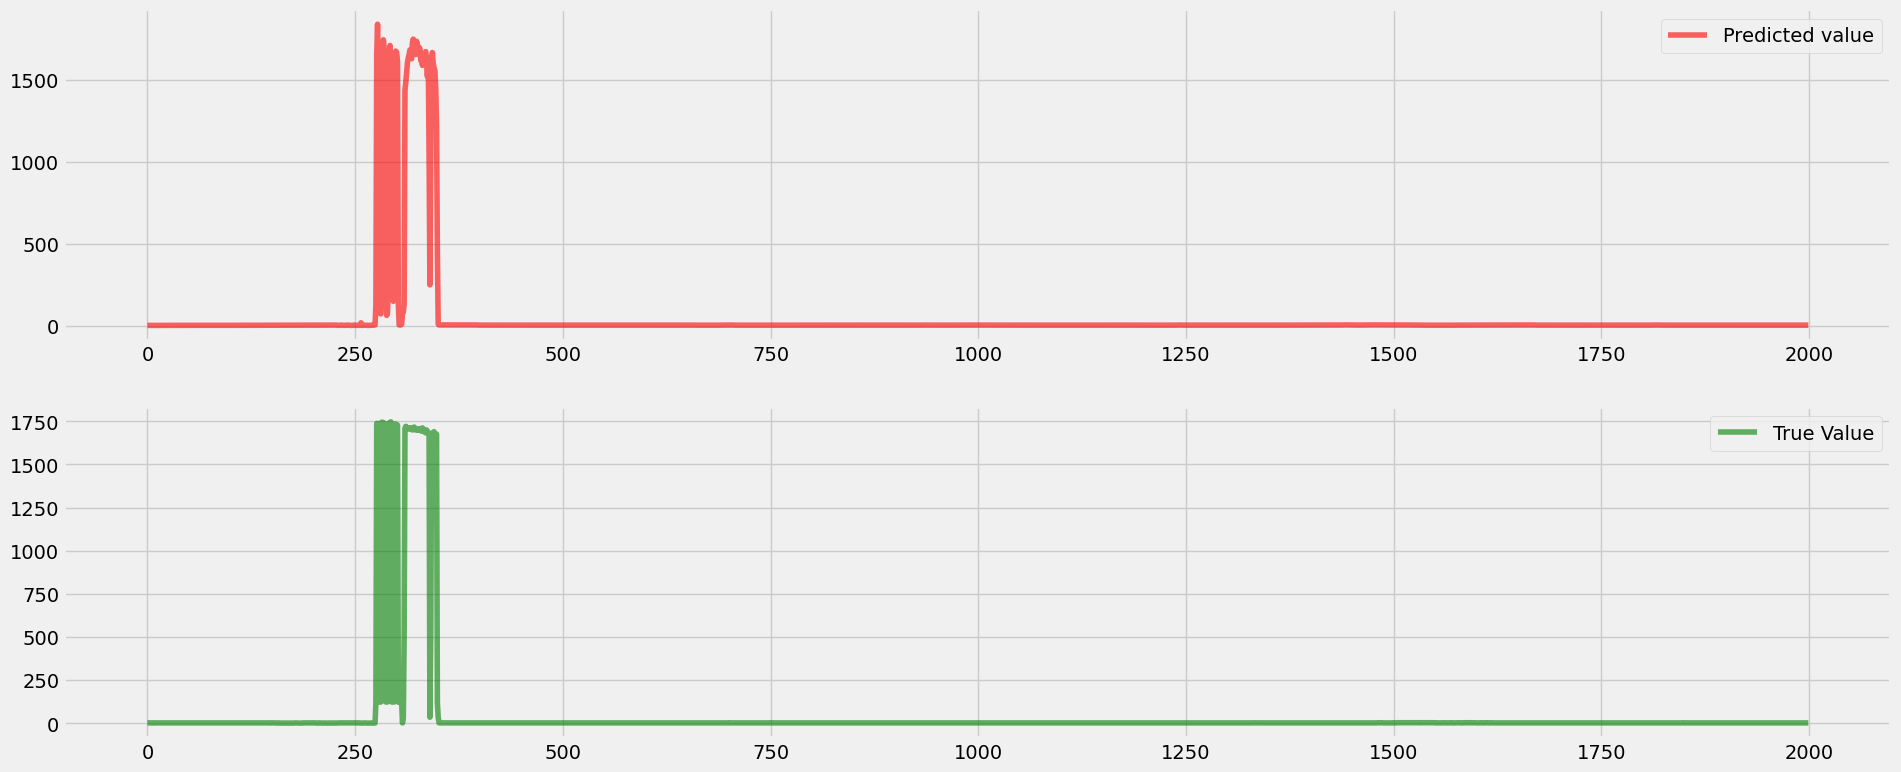

In [62]:
plt.rcParams["figure.figsize"] = [21,9]
plt.subplot(2,1,1)
plt.plot((pred.reshape(-1)*MAX_y)[:2000], color = 'r', alpha = 0.6, label = 'Predicted value')
plt.legend()
plt.subplot(2,1,2)
plt.plot((y_test_segm*MAX_y)[:2000], color = 'g', alpha = 0.6, label = 'True Value')
plt.legend()

### Without Data Augmentation

In [58]:
microwave_model=load_model("/kaggle/input/no-aug/tensorflow2/default/1/best_GRU_microwave.keras")

pred2= microwave_model.predict(X_test_segm)

mse_loss_norm = mse_loss(pred2.reshape(-1)*MAX_y, y_test_segm*MAX_y)
rpaf = recall_precision_accuracy_f1(pred2.reshape(-1)*MAX_y, y_test_segm*MAX_y, 400 )
rete = relative_error_total_energy(pred2.reshape(-1)*MAX_y, y_test_segm*MAX_y)
mae = mean_absolute_error(pred2.reshape(-1)*MAX_y, y_test_segm*MAX_y)
r2 = r_squared(pred2.reshape(-1)*MAX_y, y_test_segm*MAX_y)
print("============ Recall: {}".format(rpaf[0]))
print("============ Precision: {}".format(rpaf[1]))
print("============ Accuracy: {}".format(rpaf[2]))
print("============ F1 Score: {}".format(rpaf[3]))
print("============ R-squared:", r2)

print('============ Mean squared error: ', mse_loss_norm)
print("============ Relative error in total energy: {}".format(rete))
print("============ Mean absolute error(in Watts): {}".format(mae))


6872/6872 ━━━━━━━━━━━━━━━━━━━━ 45s 6ms/step
============ Recall: 0.7497291440953413
============ Precision: 0.3574380165289256
============ Accuracy: 0.9932918565412358
============ F1 Score: 0.4840853445260581
============ R-squared: 0.32041134096441437
============ Mean squared error:  8235.919486483222
============ Relative error in total energy: 0.430804915712798
============ Mean absolute error(in Watts): 15.107550716243681


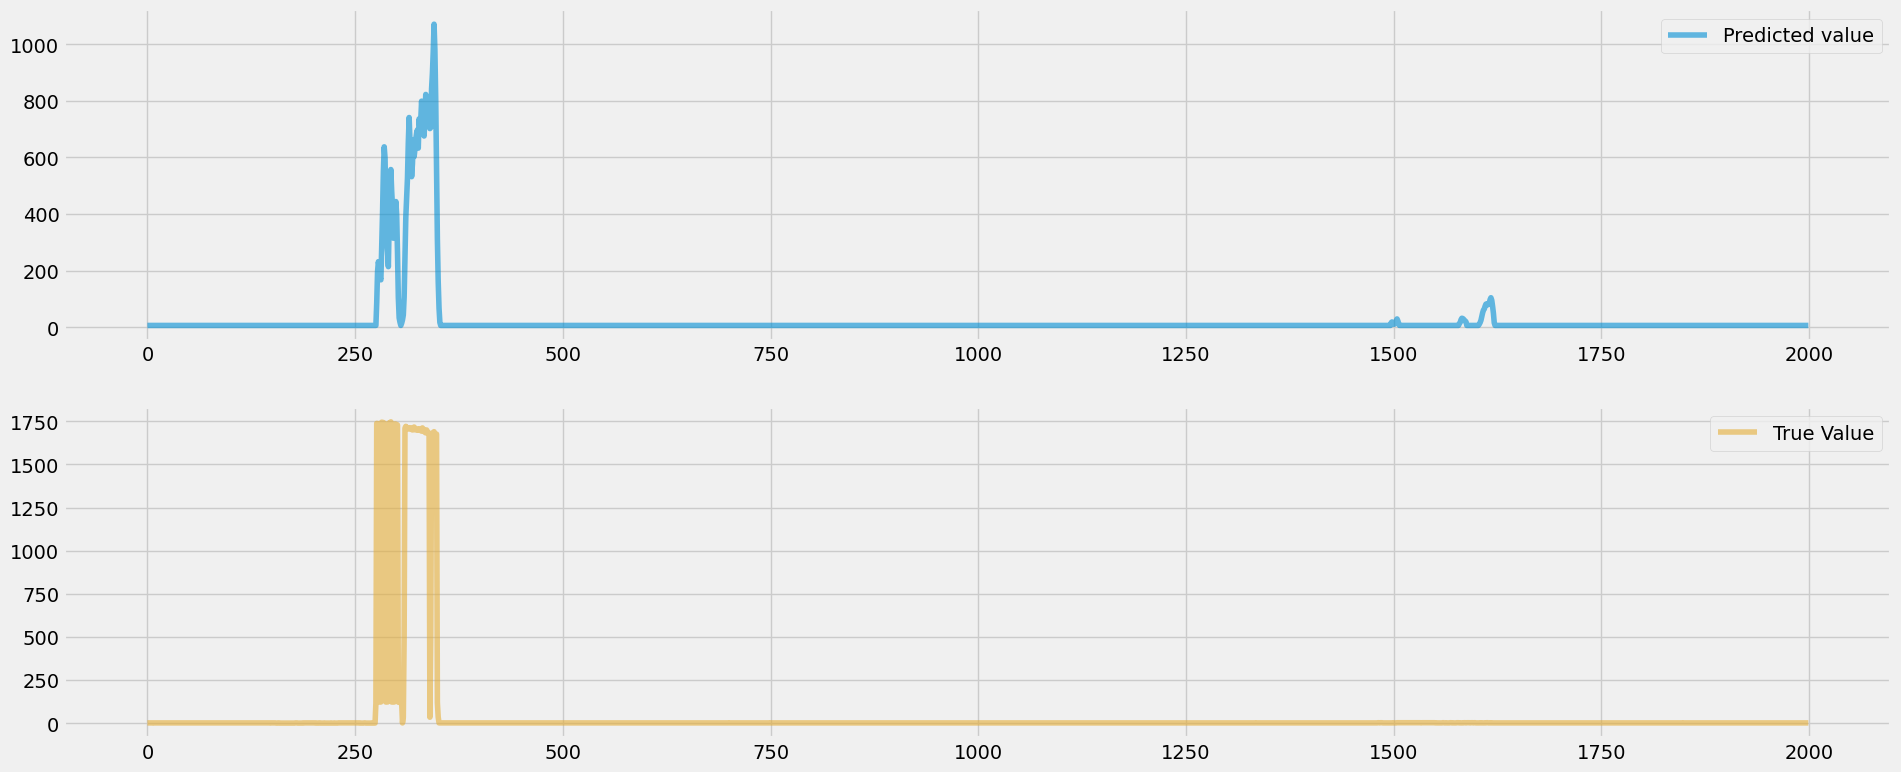

In [59]:
plt.rcParams["figure.figsize"] = [21,9]
plt.subplot(2,1,1)
plt.plot((pred2.reshape(-1)*MAX_y)[:2000], color = 'C0', alpha = 0.6, label = 'Predicted value')
plt.legend()
plt.subplot(2,1,2)
plt.plot((y_test_segm*MAX_y)[:2000], color = 'C2', alpha = 0.6, label = 'True Value')
plt.legend()

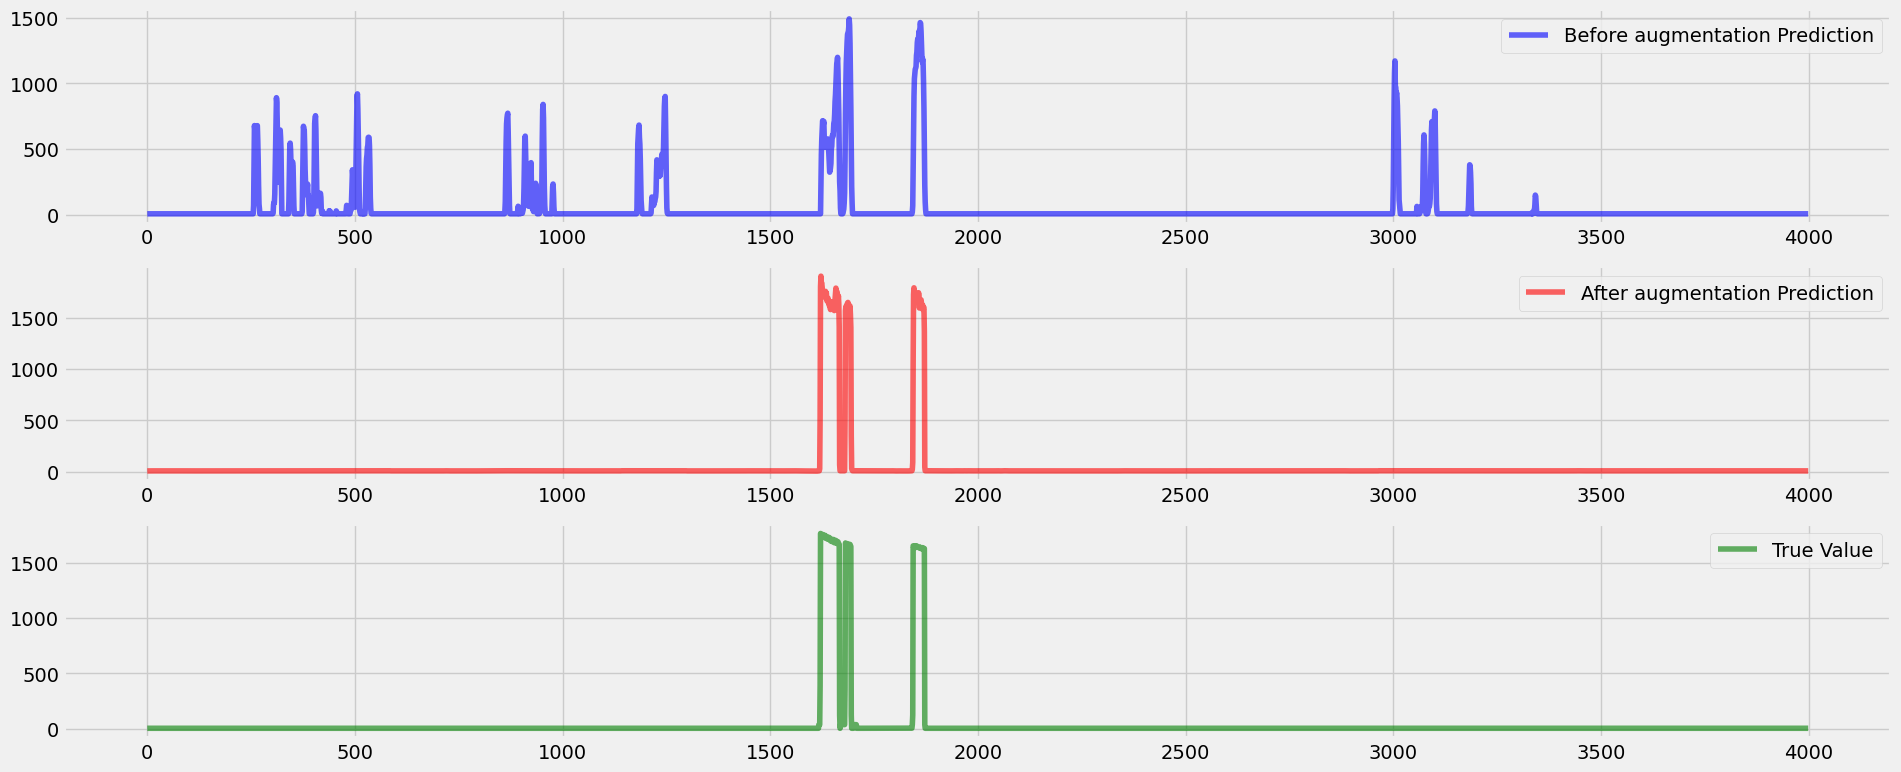

In [76]:
plt.rcParams["figure.figsize"] = [21,9]
plt.subplot(3,1,1)
plt.plot((pred2.reshape(-1)*MAX_y)[172000:176000], color = 'b', alpha = 0.6, label = 'Before augmentation Prediction')
plt.legend()
plt.subplot(3,1,2)
plt.plot((pred.reshape(-1)*MAX_y)[172000:176000], color = 'r', alpha = 0.6, label = 'After augmentation Prediction')
plt.legend()
plt.subplot(3,1,3)
plt.plot((y_test_segm*MAX_y)[172000:176000], color = 'g', alpha = 0.6, label = 'True Value')
plt.legend()

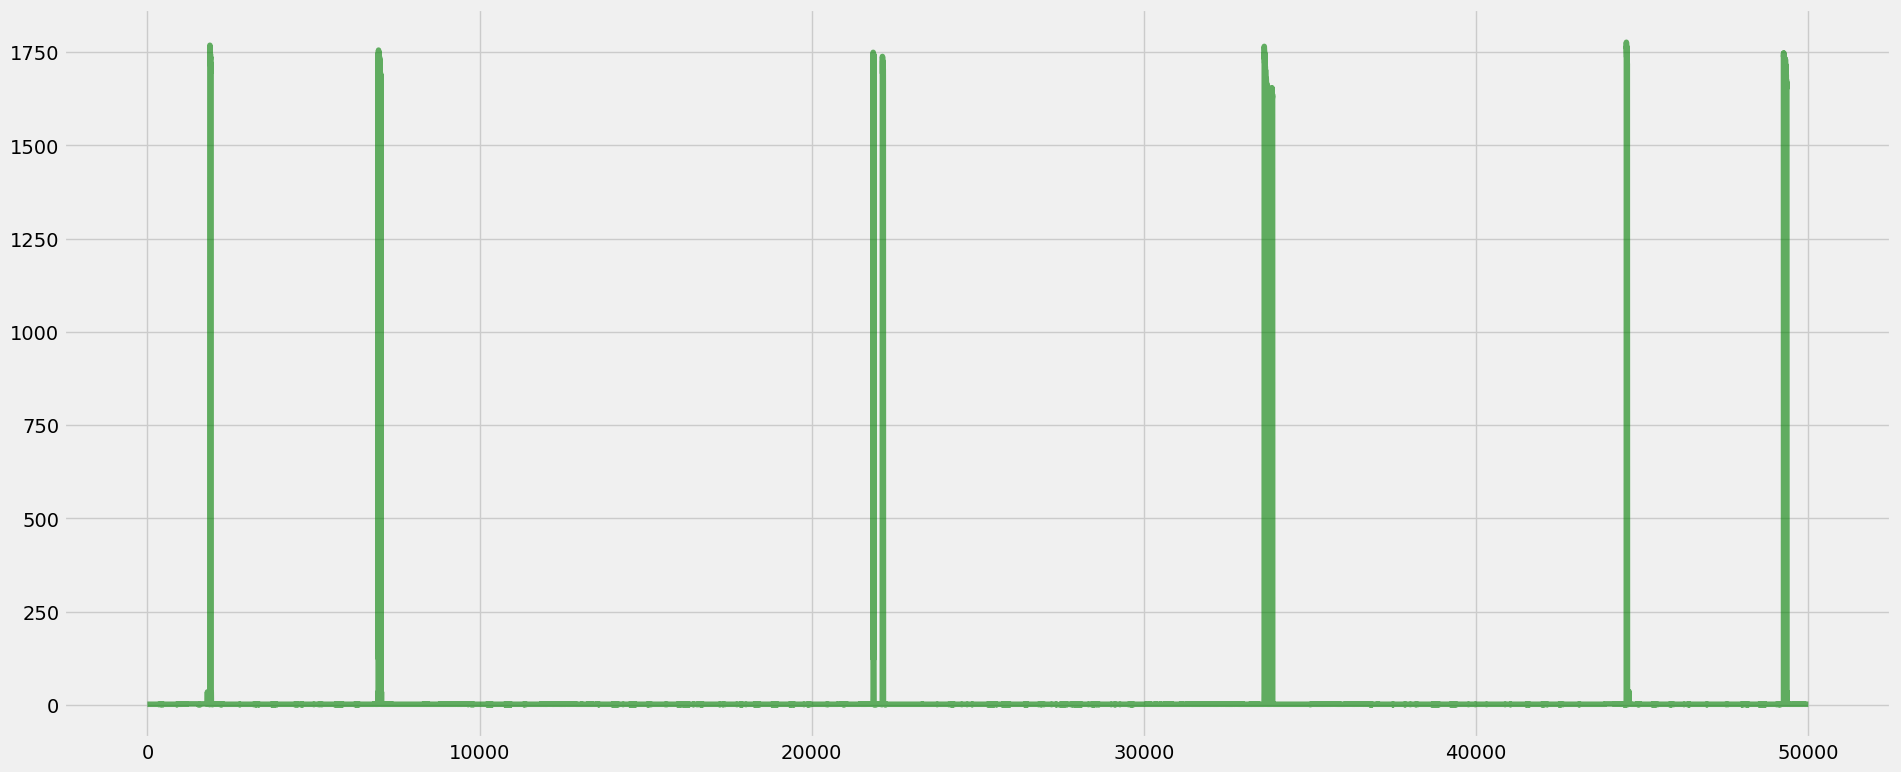

In [73]:
plt.plot((y_test_segm*MAX_y)[140000:190000], color = 'g', alpha = 0.6, label = 'True Value')

# Building Model

## TPU

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect TPU
    print('Running on TPU:', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()  # Default strategy if TPU is not available
print("REPLICAS: ", strategy.num_replicas_in_sync)


In [16]:
from keras.layers import Add ,     LayerNormalization
def create_model(time_stamp):
    inputs = Input(shape=(time_stamp, 1))

    # Convolutional Layers
    x = Conv1D(16, 4, activation="relu", padding="same", strides=1)(inputs)
    x = BatchNormalization()(x)
    x = Conv1D(32, 4, activation="relu", padding="same", strides=1)(x)
    x = BatchNormalization()(x)
    x = Conv1D(64, 4, activation="relu", padding="same", strides=1)(x)
    x = BatchNormalization()(x)

    # Bidirectional GRU Layers
    x = Bidirectional(GRU(64, return_sequences=True, stateful=False))(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(GRU(64, return_sequences=True, stateful=False))(x)
    x = Dropout(0.3)(x)

    # Attention Mechanism
    query = Dense(64)(x)
    key = Dense(64)(x)
    value = Dense(64)(x)
    attention_output = Attention()([query, key, value])

    # Project Attention Output to Match GRU Dimensions
    attention_output = Dense(128)(attention_output)  # Match to GRU output size

    # Residual Connection
    x = Add()([x, attention_output])
    x = LayerNormalization()(x)

    # Fully Connected Layers
    x = Flatten()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation="linear")(x)

    model = Model(inputs, outputs)

    # Optimizer with Reduced Learning Rate
    opt = Adam(learning_rate=0.0001)
    model.compile(loss="mse", optimizer=opt, metrics=["mae"])

    return model

In [20]:
# with strategy.scope():  ## use with tpu 
appliance='microwave'
model = create_model(windows_length)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 100, 16)   │         80 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 100, 16)   │         64 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 100, 32)   │      2,080 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 32)   │        128 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 100, 64)   │      8,256 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 64)   │        256 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 100, 128)  │     49,920 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 100, 128)  │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 100, 128)  │     74,496 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 100, 128)  │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 100, 64)   │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 100, 64)   │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 100, 64)   │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 100, 64)   │          0 │ dense[0][0],      │
│ (Attention)         │                   │            │ dense_1[0][0],    │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 100, 128)  │      8,320 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 100, 128)  │          0 │ dropout_1[0][0],  │
│                     │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 100, 128)  │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 12800)     │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │  1,638,528 │ flatten[0][0]   

 Total params: 1,807,281 (6.89 MB)

 Trainable params: 1,807,057 (6.89 MB)

 Non-trainable params: 224 (896.00 B)

In [21]:
# with strategy.scope():  ##use with tpu 
    
# BATCH_SIZE = 64 * strategy.num_replicas_in_sync  #
ckpt = ModelCheckpoint(filepath=f"/kaggle/working/best_GRU_{appliance}.keras", verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=3, verbose=1, min_lr=0.000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001, mode='min', verbose=1)

history = model.fit(
    X_train_segm, 
    y_train_segm, 
#     X_seg, 
#     y_seg, 
    epochs=30,
    batch_size=128, 
    validation_split=0.2 ,
#     validation_data=(X_test_seg, y_test_seg),
    shuffle=True,
    callbacks=[ckpt, reduce_lr, early_stopping]
)

model = load_model(f"/kaggle/working/best_GRU_{appliance}.keras")

Epoch 1/30
5498/5498 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1043 - mae: 0.0833
Epoch 1: val_loss improved from inf to 0.00254, saving model to /kaggle/working/best_GRU_microwave.keras
5498/5498 ━━━━━━━━━━━━━━━━━━━━ 193s 33ms/step - loss: 0.1043 - mae: 0.0833 - val_loss: 0.0025 - val_mae: 0.0093 - learning_rate: 1.0000e-04
Epoch 2/30
5497/5498 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0021 - mae: 0.0072
Epoch 2: val_loss did not improve from 0.00254
5498/5498 ━━━━━━━━━━━━━━━━━━━━ 184s 33ms/step - loss: 0.0021 - mae: 0.0072 - val_loss: 0.0038 - val_mae: 0.0136 - learning_rate: 1.0000e-04
Epoch 3/30
5497/5498 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0016 - mae: 0.0060
Epoch 3: val_loss did not improve from 0.00254
5498/5498 ━━━━━━━━━━━━━━━━━━━━ 183s 33ms/step - loss: 0.0016 - mae: 0.0060 - val_loss: 0.0032 - val_mae: 0.0097 - learning_rate: 1.0000e-04
Epoch 4/30
5497/5498 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0013 - mae: 0.0056
Epoch 4: val_loss did not improve from 0.0025

## Visualising model performance 

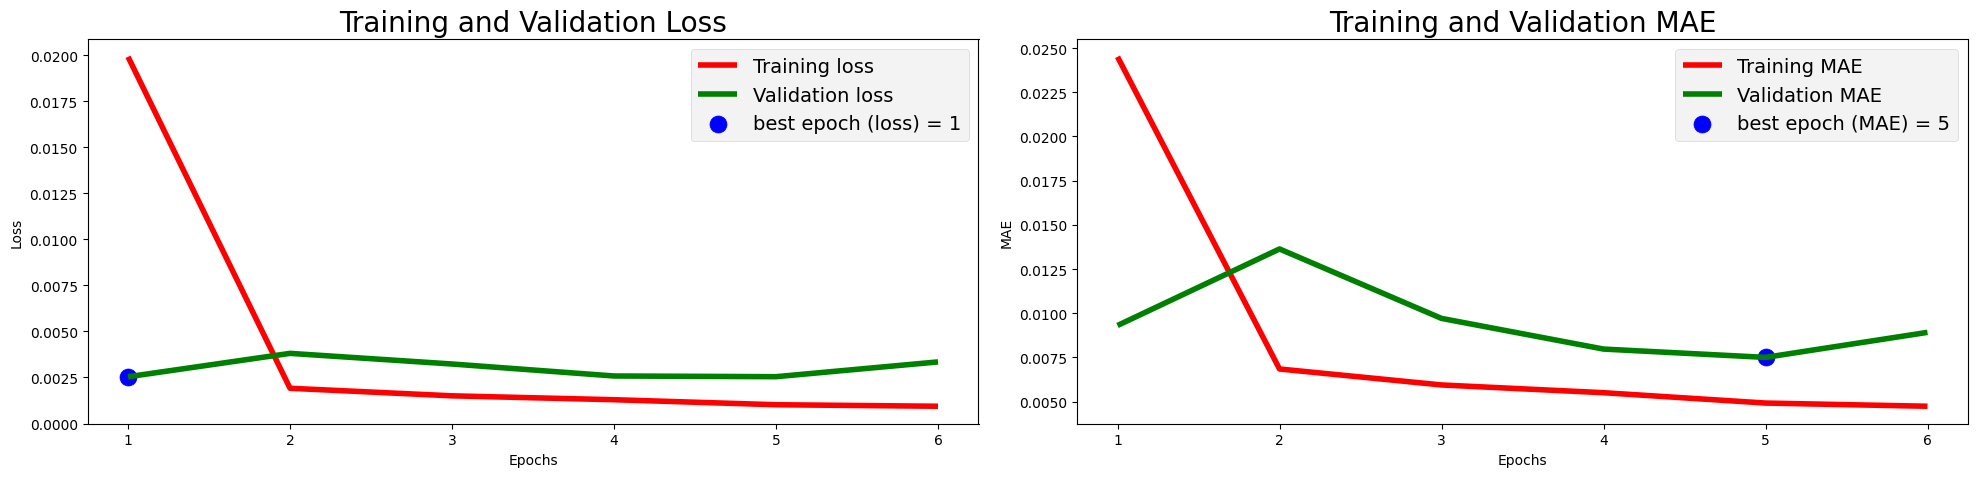

In [22]:
tr_loss = history.history['loss']
val_loss = history.history['val_loss']
tr_mae = history.history['mae']
val_mae = history.history['val_mae']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_mae = np.argmin(val_mae)
mae_lowest = val_mae[index_mae]

Epochs = [i + 1 for i in range(len(tr_loss))]
loss_label = f'best epoch (loss) = {str(index_loss + 1)}'
mae_label = f'best epoch (MAE) = {str(index_mae + 1)}'

fig, axes = plt.subplots(1, 2, figsize=(20, 5))
plt.style.use('fivethirtyeight')

# Plot losses
axes[0].plot(Epochs, tr_loss, 'r', label='Training loss')
axes[0].plot(Epochs, val_loss, 'g', label='Validation loss')
axes[0].scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot MAE
axes[1].plot(Epochs, tr_mae, 'r', label='Training MAE')
axes[1].plot(Epochs, val_mae, 'g', label='Validation MAE')
axes[1].scatter(index_mae + 1, mae_lowest, s=150, c='blue', label=mae_label)
axes[1].set_title('Training and Validation MAE')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('MAE')
axes[1].legend()

plt.tight_layout()
plt.show()


# Data Augmentation Using GANs

## Select Gan training samples 

In [17]:
window_size = 300

train_set = []              
for y in y_list :
    for i in range(0, len(y) - window_size + 1, window_size):
        window = y[i:i + window_size]

        if np.sum(window > 100) >= 10 :
            train_set.append(window)
train_set = np.array(train_set)
print("Extracted active Microwave windows shape:", train_set.shape)

Extracted active Microwave windows shape: (192, 300)


In [18]:
from scipy.signal import find_peaks

def count_fluctuations(signal):
#     peaks, _ = find_peaks(signal, height=100, distance=10, prominence=50)
    peaks, _ = find_peaks(signal, height=30, distance=5, prominence=50) 
    return len(peaks)



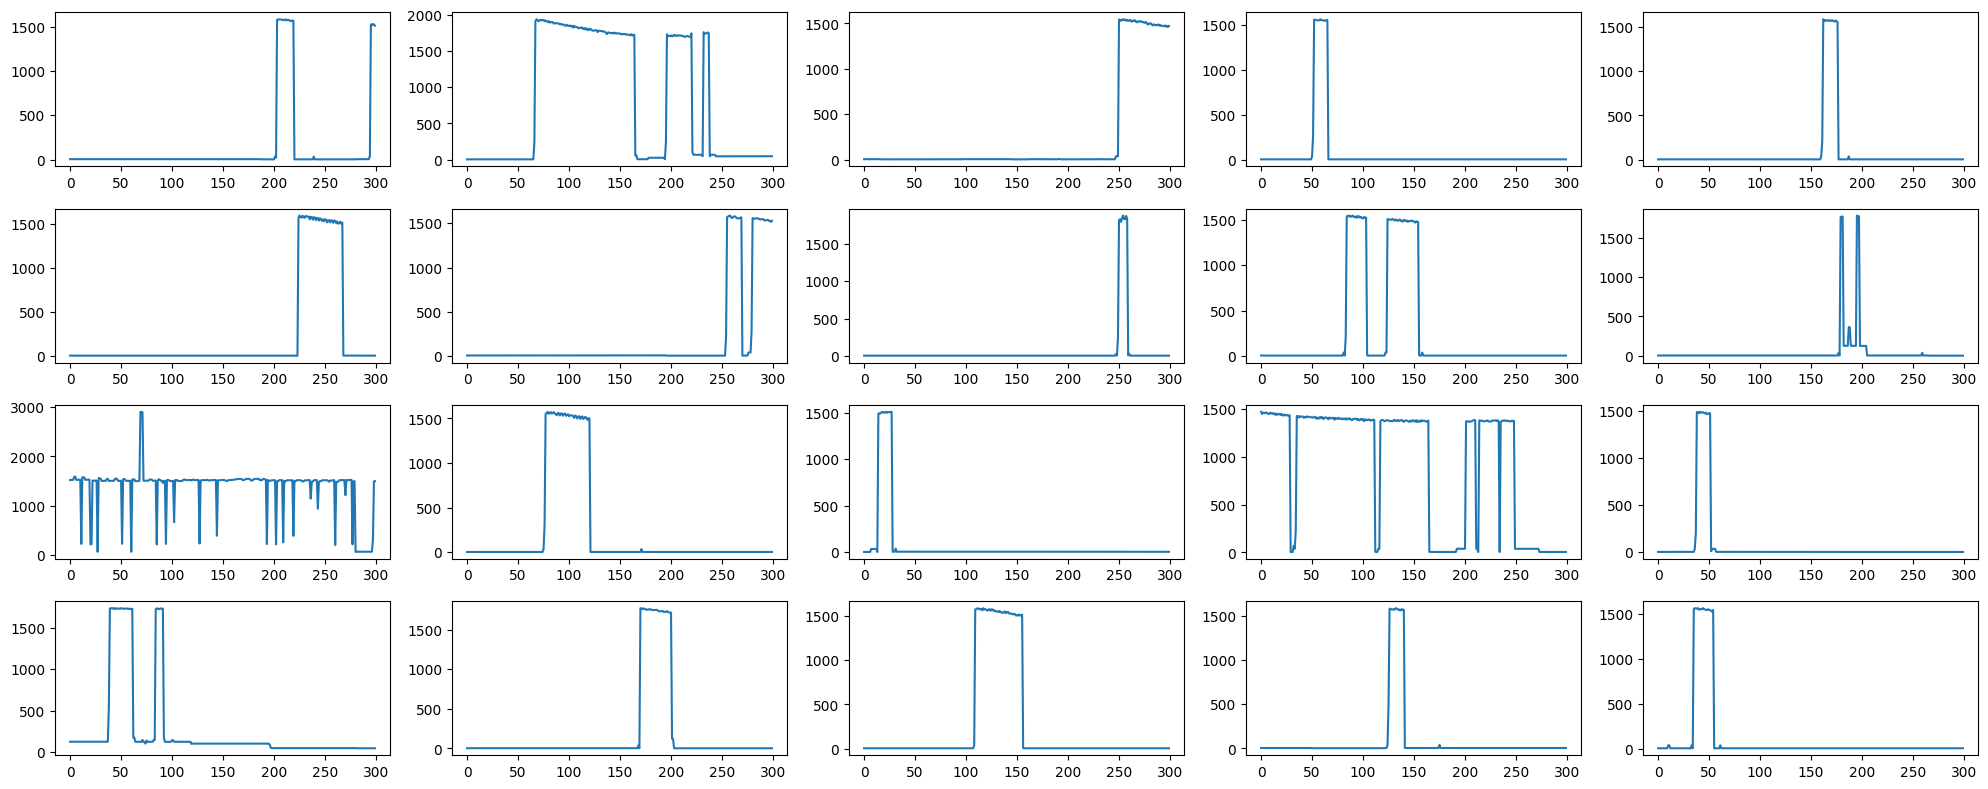

In [19]:
import random
train_set_list = train_set.tolist()
plt.figure(figsize=(20,8))
nb=20
for i , sample in enumerate(random.sample(train_set_list,nb)):
    plt.subplot(nb//5,5,i+1)
    plt.plot(sample)
    # plt.title(f"{count_fluctuations(sample):.2f}")
plt.tight_layout()


## Create GAN 

### Gan for load disaggregation

In [ ]:
from keras.layers import Concatenate, Input, Conv1D, Conv1DTranspose, Dense, Flatten, Reshape

def create_seeder(input_shape):
    model = Sequential([
        Conv1D(256, kernel_size=8, strides=1, activation='relu', input_shape=input_shape),
        Conv1D(128, kernel_size=16, strides=1, activation='relu'),
        Conv1D(64, kernel_size=32, strides=1, activation='relu'),
        Flatten(),
        Dense(128, activation='relu'), 
    ])
    return model

def create_generator(latent_dim, output_shape):
    model = Sequential([
        Dense(64 * (output_shape[0] // 4), activation='relu', input_dim=latent_dim),
        Reshape((output_shape[0] // 4, 64)),
        Conv1DTranspose(128, kernel_size=4, strides=2, activation='relu', padding='same'),
        Conv1DTranspose(64, kernel_size=4, strides=2, activation='relu', padding='same'),
        Conv1D(1, kernel_size=3, activation='tanh', padding='same') 
    ])
    return model

def create_discriminator(input_shape):
    model = Sequential([
        Conv1D(512, kernel_size=32, strides=1, activation='relu', input_shape=input_shape),
        Conv1D(256, kernel_size=16, strides=1, activation='relu'),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

def train_gan(generator, discriminator, gan, seeder, X, y_real, epochs=200, batch_size=64):

    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    for epoch in range(epochs):

        idx = np.random.randint(0, X.shape[0], batch_size)
        real_aggregate = X[idx]
        real_microwave = y_real[idx]
        
#         z = seeder.predict(real_aggregate, verbose=0)
        z = seeder.predict(real_aggregate + 10 * np.random.normal(size=real_aggregate.shape))

        generated_microwave = generator.predict(z, verbose=0)
        
        real_aggregate = np.expand_dims(real_aggregate, axis=-1)
        real_microwave = np.expand_dims(real_microwave, axis=-1)
        
#         print(real_aggregate.shape)
#         print(real_microwave.shape)

        d_loss_real, d_acc_real = discriminator.train_on_batch(np.concatenate([real_aggregate, real_microwave], axis=-1), real_labels)
        d_loss_fake, d_acc_fake = discriminator.train_on_batch(np.concatenate([real_aggregate, generated_microwave], axis=-1), fake_labels)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)

        g_loss = gan.train_on_batch(real_aggregate, real_labels)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{epochs} - D loss Real: {d_loss_real:.4f}, D Acc Real: {d_acc_real:.4f}, "
                  f"D loss Fake: {d_loss_fake:.4f}, D Acc Fake: {d_acc_fake:.4f}, G loss: {g_loss[0]:.4f}")


In [ ]:
input_shape = (windows_length, 1) 
latent_dim = 128 

seeder = create_seeder(input_shape)
generator = create_generator(latent_dim, input_shape)
discriminator = create_discriminator((input_shape[0], 2)) 

p = Input(shape=input_shape) 
z = seeder(p) 
p_j_hat = generator(z)
concatenated = Concatenate(axis=-1)([p, p_j_hat])
validity = discriminator(concatenated)

optimizer = Adam(learning_rate= 0.0002, beta_1=0.5)
discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

gan_model = Model(p, validity)
gan_optimizer = Adam(learning_rate= 0.0002, beta_1=0.5)
gan_model.compile(optimizer=gan_optimizer, loss='binary_crossentropy')


In [ ]:
# train_gan(generator, discriminator, gan_model, seeder, X_train_seg, y_segments, epochs=1000, batch_size=32) 
train_gan(generator, discriminator, gan_model, seeder, X_seg, y_seg, epochs=500, batch_size=32) 

In [ ]:
# X_i,y_i = get_odd_data(X1, y1, MAX_X, MAX_y)
# X_seg_i,y_seg_i_mean , y_seg_i   = shift_segment(X_i,y_i,windows_length,stride)
# X_seg_i=np.expand_dims(X_seg_i, axis=2)
z_samples = seeder.predict(X_seg) 
synthetic_microwave_data = generator.predict(z_samples) 
pred = np.mean(synthetic_microwave_data, axis=1).flatten()

In [ ]:
plt.plot((pred*MAX_y)[50000:100000], color = 'C0', alpha = 0.6, label = 'synthetic data')
plt.plot((y_seg_i_mean*MAX_y)[50000:100000], color = 'C3', alpha = 0.6, label = 'True data')
plt.legend()

### GAN for data Augmentation 

### old Arch

In [ ]:
# import torch.nn.functional as F

# # Self-Attention module
# class SelfAttention(nn.Module):
#     def __init__(self, embed_dim, num_heads):
#         super(SelfAttention, self).__init__()
#         self.attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
#         self.norm = nn.LayerNorm(embed_dim)
    
#     def forward(self, x):
#         # Ensure x is of shape (batch_size, seq_len, embed_dim)
#         attn_output, _ = self.attention(x, x, x)
#         return self.norm(x + attn_output)

# class Generator(nn.Module):
#     def __init__(self, latent_dim, window_length):
#         super(Generator, self).__init__()
#         self.fc = nn.Sequential(
#             nn.Linear(latent_dim, window_length * 4),
#             nn.LeakyReLU(0.2),
#             nn.BatchNorm1d(window_length * 4)
#         )
#         self.reshape_dim = (4, window_length)
        
#         self.conv1 = nn.Sequential(
#             nn.Conv1d(4, 64, kernel_size=3, padding=1),
#             nn.LeakyReLU(0.2),
#             nn.BatchNorm1d(64)
#         )
#         self.attn1 = SelfAttention(64, num_heads=4)
        
#         self.conv2 = nn.Sequential(
#             nn.Conv1d(64, 128, kernel_size=3, padding=1),
#             nn.LeakyReLU(0.2),
#             nn.BatchNorm1d(128)
#         )
#         self.attn2 = SelfAttention(128, num_heads=4)
        
#         self.conv3 = nn.Sequential(
#             nn.Conv1d(128, 64, kernel_size=3, padding=1),
#             nn.LeakyReLU(0.2),
#             nn.BatchNorm1d(64)
#         )
        
#         self.fc_out = nn.Conv1d(64, 1, kernel_size=1)
    
#     def forward(self, z):
#         x = self.fc(z)
#         x = x.view(-1, *self.reshape_dim) 
#         x = self.conv1(x)
#         x = x.permute(0, 2, 1)  
#         x = self.attn1(x) 
#         x = x.permute(0, 2, 1)
#         x = self.conv2(x)
#         x = x.permute(0, 2, 1) 
#         x = self.attn2(x)  
#         x = x.permute(0, 2, 1)
#         x = self.conv3(x)
#         return torch.tanh(self.fc_out(x))
# #         return torch.sigmoid(self.fc_out(x))

# # Discriminator Model
# class Discriminator(nn.Module):
#     def __init__(self, input_shape):
#         super(Discriminator, self).__init__()
                
#         self.conv1 = nn.Sequential(
#             nn.Conv1d(1, 32, kernel_size=3, padding=1),
#             nn.LeakyReLU(0.2),
#             nn.Dropout(0.3)
#         )        
#         self.conv2 = nn.Sequential(
#             nn.Conv1d(32, 64, kernel_size=3, padding=1),
#             nn.LeakyReLU(0.2),
#             nn.Dropout(0.3)
#         )        
#         self.attn1 = SelfAttention(32, num_heads=4)
#         self.attn2 = SelfAttention(64, num_heads=4)
        
#         self.fc = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(64 * input_shape[0], 64),
#             nn.LeakyReLU(0.2),
#             nn.Linear(64, 1),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         x = self.conv1(x)
#         x = x.permute(0, 2, 1) 
#         x = self.attn1(x) 
#         x = x.permute(0, 2, 1) 
#         x = self.conv2(x)
#         x = x.permute(0, 2, 1)  
#         x = self.attn2(x)  
#         return self.fc(x)


# # Training function
# def train(g_model, d_model, g_optimizer, d_optimizer, criterion, dataset, latent_dim, device, n_epochs=10, n_batch=64, label_smoothing=0.3):
#     n_samples = len(dataset)
#     steps_per_epoch = n_samples // n_batch
#     dataset_list = dataset.tolist()
    
#     for epoch in range(1, n_epochs + 1):
#         np.random.shuffle(dataset)
        
#         for step in range(steps_per_epoch):
#             real_samples = dataset[step * n_batch: (step + 1) * n_batch]
#             X_real = torch.tensor(real_samples, dtype=torch.float32).unsqueeze(1).to(device)
            
#             # Apply label smoothing here
#             y_real = torch.ones((n_batch, 1), dtype=torch.float32).to(device) * (1 - label_smoothing)
#             y_fake = torch.zeros((n_batch, 1), dtype=torch.float32).to(device) + label_smoothing
            
#             d_optimizer.zero_grad()
#             d_loss_real = criterion(d_model(X_real), y_real)
#             d_loss_real.backward()
            
#             # Generate fake samples from the generator
#             z_input = torch.rand(n_batch, latent_dim).to(device)
#             X_fake = g_model(z_input)
            
#             # Train the discriminator on fake samples
#             d_loss_fake = criterion(d_model(X_fake.detach()), y_fake) 
#             d_loss_fake.backward()
#             d_optimizer.step()
            
#             # Train the generator (via GAN model)
#             g_optimizer.zero_grad()
#             y_gan = torch.ones((n_batch, 1), dtype=torch.float32).to(device) * (1 - label_smoothing)
#             g_loss = criterion(d_model(X_fake), y_gan)
#             g_loss.backward()
            
#             # Update the generator
#             g_optimizer.step()
            
#             # Print the losses at regular intervals
#         if epoch % 50 == 0:
#             print(f'Epoch {epoch}/{n_epochs}, '
#                   f'd_loss_real={d_loss_real.item():.3f}, d_loss_fake={d_loss_fake.item():.3f}, '
#                   f'g_loss={g_loss.item():.3f}')

            
# # Initialize models and optimizer
# latent_dim = 50
# window_length = 300
# g_model = Generator(latent_dim, window_length)
# d_model = Discriminator((window_length, 1))

# # Optimizers
# g_optimizer = optim.Adam(g_model.parameters(), lr=0.00005, betas=(0.5, 0.999))
# d_optimizer = optim.Adam(d_model.parameters(), lr=0.0003, betas=(0.5, 0.999))

# # Loss function
# criterion = nn.BCELoss()

# # Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# g_model.to(device)
# d_model.to(device)

In [113]:
!pip install torchviz 


In [116]:
from torchviz import make_dot
import torch

model = Generator(latent_dim=64, window_length=300)  # Your generator model
z = torch.rand(128, 64) # Example input
y = model(z)  # Forward pass
make_dot(y, params=dict(model.named_parameters())).render("generator", format="png")


'generator.png'

In [20]:
import torch.nn.functional as F

# Self-Attention module
class SelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(SelfAttention, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        self.norm = nn.LayerNorm(embed_dim)
    
    def forward(self, x):
        # Ensure x is of shape (batch_size, seq_len, embed_dim)
        attn_output, _ = self.attention(x, x, x)
        return self.norm(x + attn_output)

class Generator(nn.Module):
    def __init__(self, latent_dim, window_length):
        super(Generator, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(latent_dim, window_length * 8),  # Increased output size
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(window_length * 8)
        )
        
        self.reshape_dim = (8, window_length)
        
        self.conv1 = nn.Sequential(
            nn.Conv1d(8, 128, kernel_size=3, padding=1),  # Increased output channels
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3)  # Dropout for regularization
        )
        
        self.attn1 = SelfAttention(128, num_heads=4)
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=3, padding=1),  # Increased channels
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3)  # Dropout for regularization
        )
        
        self.attn2 = SelfAttention(256, num_heads=4)
        
        self.conv3 = nn.Sequential(
            nn.Conv1d(256, 128, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3)
        )
        
        self.residual1 = nn.Conv1d(256, 128, kernel_size=1)  # Adjusted to match dimensions
        
        self.fc_out = nn.Conv1d(128, 1, kernel_size=1)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, *self.reshape_dim)  # Reshape to (batch_size, channels, seq_len)
        
        x1 = self.conv1(x)
        x1 = x1.permute(0, 2, 1)  
        x1 = self.attn1(x1)
        x1 = x1.permute(0, 2, 1)  
        
        x2 = self.conv2(x1)
        x2 = x2.permute(0, 2, 1)
        x2 = self.attn2(x2)
        x2 = x2.permute(0, 2, 1)
        
        x3 = self.conv3(x2)
        
        x3 += self.residual1(x2)  # Apply residual connection with adjusted channels
        
        return torch.sigmoid(self.fc_out(x3))


# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()
                
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )        
        self.conv2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )        
        self.attn1 = SelfAttention(32, num_heads=4)
        self.attn2 = SelfAttention(64, num_heads=4)
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * input_shape[0], 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = x.permute(0, 2, 1) 
        x = self.attn1(x) 
        x = x.permute(0, 2, 1) 
        x = self.conv2(x)
        x = x.permute(0, 2, 1)  
        x = self.attn2(x)  
        return self.fc(x)

# old train 
def train(g_model, d_model, g_optimizer, d_optimizer, criterion, dataset, latent_dim, device, n_epochs=10, n_batch=64, label_smoothing=0.3):
    n_samples = len(dataset)
    steps_per_epoch = n_samples // n_batch
    dataset_list = dataset.tolist()
    
    for epoch in range(1, n_epochs + 1):
        np.random.shuffle(dataset)
        
        for step in range(steps_per_epoch):
            real_samples = dataset[step * n_batch: (step + 1) * n_batch]
            X_real = torch.tensor(real_samples, dtype=torch.float32).unsqueeze(1).to(device)
            
            # Apply label smoothing here
            y_real = torch.ones((n_batch, 1), dtype=torch.float32).to(device) * (1 - label_smoothing)
            y_fake = torch.zeros((n_batch, 1), dtype=torch.float32).to(device) + label_smoothing
            
            d_optimizer.zero_grad()
            d_loss_real = criterion(d_model(X_real), y_real)
            d_loss_real.backward()
            
            # Generate fake samples from the generator
            z_input = torch.rand(n_batch, latent_dim).to(device)
            X_fake = g_model(z_input)
            
            # Train the discriminator on fake samples
            d_loss_fake = criterion(d_model(X_fake.detach()), y_fake) 
            d_loss_fake.backward()
            d_optimizer.step()
            
            # Train the generator (via GAN model)
            g_optimizer.zero_grad()
            y_gan = torch.ones((n_batch, 1), dtype=torch.float32).to(device) * (1 - label_smoothing)
            g_loss = criterion(d_model(X_fake), y_gan)
            g_loss.backward()
            
            # Update the generator
            g_optimizer.step()
            
            # Print the losses at regular intervals
        if epoch % 50 == 0:
            print(f'Epoch {epoch}/{n_epochs}, '
                  f'd_loss_real={d_loss_real.item():.3f}, d_loss_fake={d_loss_fake.item():.3f}, '
                  f'g_loss={g_loss.item():.3f}')

        
# Initialize models and optimizer
latent_dim = 64
window_length = 300
g_model = Generator(latent_dim, window_length)
d_model = Discriminator((window_length, 1))

# Optimizers
g_optimizer = optim.Adam(g_model.parameters(), lr=0.00005, betas=(0.5, 0.999))
d_optimizer = optim.Adam(d_model.parameters(), lr=0.0003, betas=(0.5, 0.999))

# Loss function
criterion = nn.BCELoss()
mse_criterion= nn.MSELoss()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
g_model.to(device)
d_model.to(device)

Discriminator(
  (conv1): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (attn1): SelfAttention(
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
    )
    (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  )
  (attn2): SelfAttention(
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
    )
    (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=19200, out_features=64, bias=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): L

In [27]:
train(g_model, d_model, g_optimizer, d_optimizer, criterion, train_set/MAX_y , latent_dim, device, n_epochs=4000, n_batch=128)

# train(g_model, d_model, g_optimizer, d_optimizer, criterion, mse_criterion, np.array(non_noisy_signals)/MAX_y , latent_dim, device, n_epochs=3000, n_batch=25)

# train(g_model, d_model, g_optimizer, d_optimizer, criterion,mse_criterion, train_set/MAX_y , latent_dim, device, n_epochs=2500, n_batch=25 )

Epoch 50/4000, d_loss_real=0.634, d_loss_fake=0.622, g_loss=0.875
Epoch 100/4000, d_loss_real=0.620, d_loss_fake=0.625, g_loss=0.923
Epoch 150/4000, d_loss_real=0.622, d_loss_fake=0.624, g_loss=0.904
Epoch 200/4000, d_loss_real=0.622, d_loss_fake=0.624, g_loss=0.916
Epoch 250/4000, d_loss_real=0.619, d_loss_fake=0.624, g_loss=0.930
Epoch 300/4000, d_loss_real=0.622, d_loss_fake=0.623, g_loss=0.934
Epoch 350/4000, d_loss_real=0.618, d_loss_fake=0.624, g_loss=0.942
Epoch 400/4000, d_loss_real=0.619, d_loss_fake=0.626, g_loss=0.929
Epoch 450/4000, d_loss_real=0.630, d_loss_fake=0.619, g_loss=0.904
Epoch 500/4000, d_loss_real=0.624, d_loss_fake=0.621, g_loss=0.896
Epoch 550/4000, d_loss_real=0.622, d_loss_fake=0.620, g_loss=0.908
Epoch 600/4000, d_loss_real=0.619, d_loss_fake=0.626, g_loss=0.917
Epoch 650/4000, d_loss_real=0.623, d_loss_fake=0.622, g_loss=0.899
Epoch 700/4000, d_loss_real=0.618, d_loss_fake=0.623, g_loss=0.939
Epoch 750/4000, d_loss_real=0.619, d_loss_fake=0.625, g_loss=0.

In [28]:
torch.save(g_model.state_dict(), "generator_model.pth")
print("Generator model saved successfully.")

Generator model saved successfully.


In [29]:
loaded_g_model = Generator(latent_dim, window_length)
loaded_g_model.load_state_dict(torch.load("generator_model.pth"))
loaded_g_model.to(device)

print("Generator model loaded successfully.")

Generator model loaded successfully.


In [30]:
def generate_synthetic_data(g_model, latent_dim, n_samples, device):
    z_input = torch.randn(n_samples, latent_dim).to(device)  
    synthetic_data = g_model(z_input)  
    return synthetic_data.cpu().detach().numpy()  

synthetic_data = generate_synthetic_data(loaded_g_model, latent_dim, 200, device)
synthetic_data = synthetic_data.squeeze(1)
synthetic_data = synthetic_data*MAX_y

### Test Discriminator 

In [31]:
# Ensure dataset is a torch.Tensor
# dataset = torch.tensor(np.array(non_noisy_signals)  / MAX_y, dtype=torch.float32).unsqueeze(1).to(device) 
dataset = torch.tensor(np.array(train_set)  / MAX_y, dtype=torch.float32).unsqueeze(1).to(device) 

# Labels for real and fake data
real_labels = torch.ones(len(dataset), 1, dtype=torch.float32).to(device)
fake_labels = torch.zeros(len(synthetic_data), 1, dtype=torch.float32).to(device)

with torch.no_grad():
    # Evaluate real data
    real_predictions = d_model(dataset)
    real_accuracy = torch.mean(((real_predictions > 0.5).float() == real_labels).float()).item()

    # Evaluate synthetic data
    synthetic_data_tensor = torch.tensor(synthetic_data, dtype=torch.float32).unsqueeze(1).to(device)
    fake_predictions = d_model(synthetic_data_tensor)
    fake_accuracy = torch.mean(((fake_predictions <= 0.5).float() == fake_labels).float()).item()

print(f"Discriminator Accuracy on Real Data: {real_accuracy * 100:.2f}% Real ")
print(f"Discriminator Accuracy on Synthetic Data: {fake_accuracy * 100:.2f}% Fake ")


Discriminator Accuracy on Real Data: 100.00% Real 
Discriminator Accuracy on Synthetic Data: 99.50% Fake 


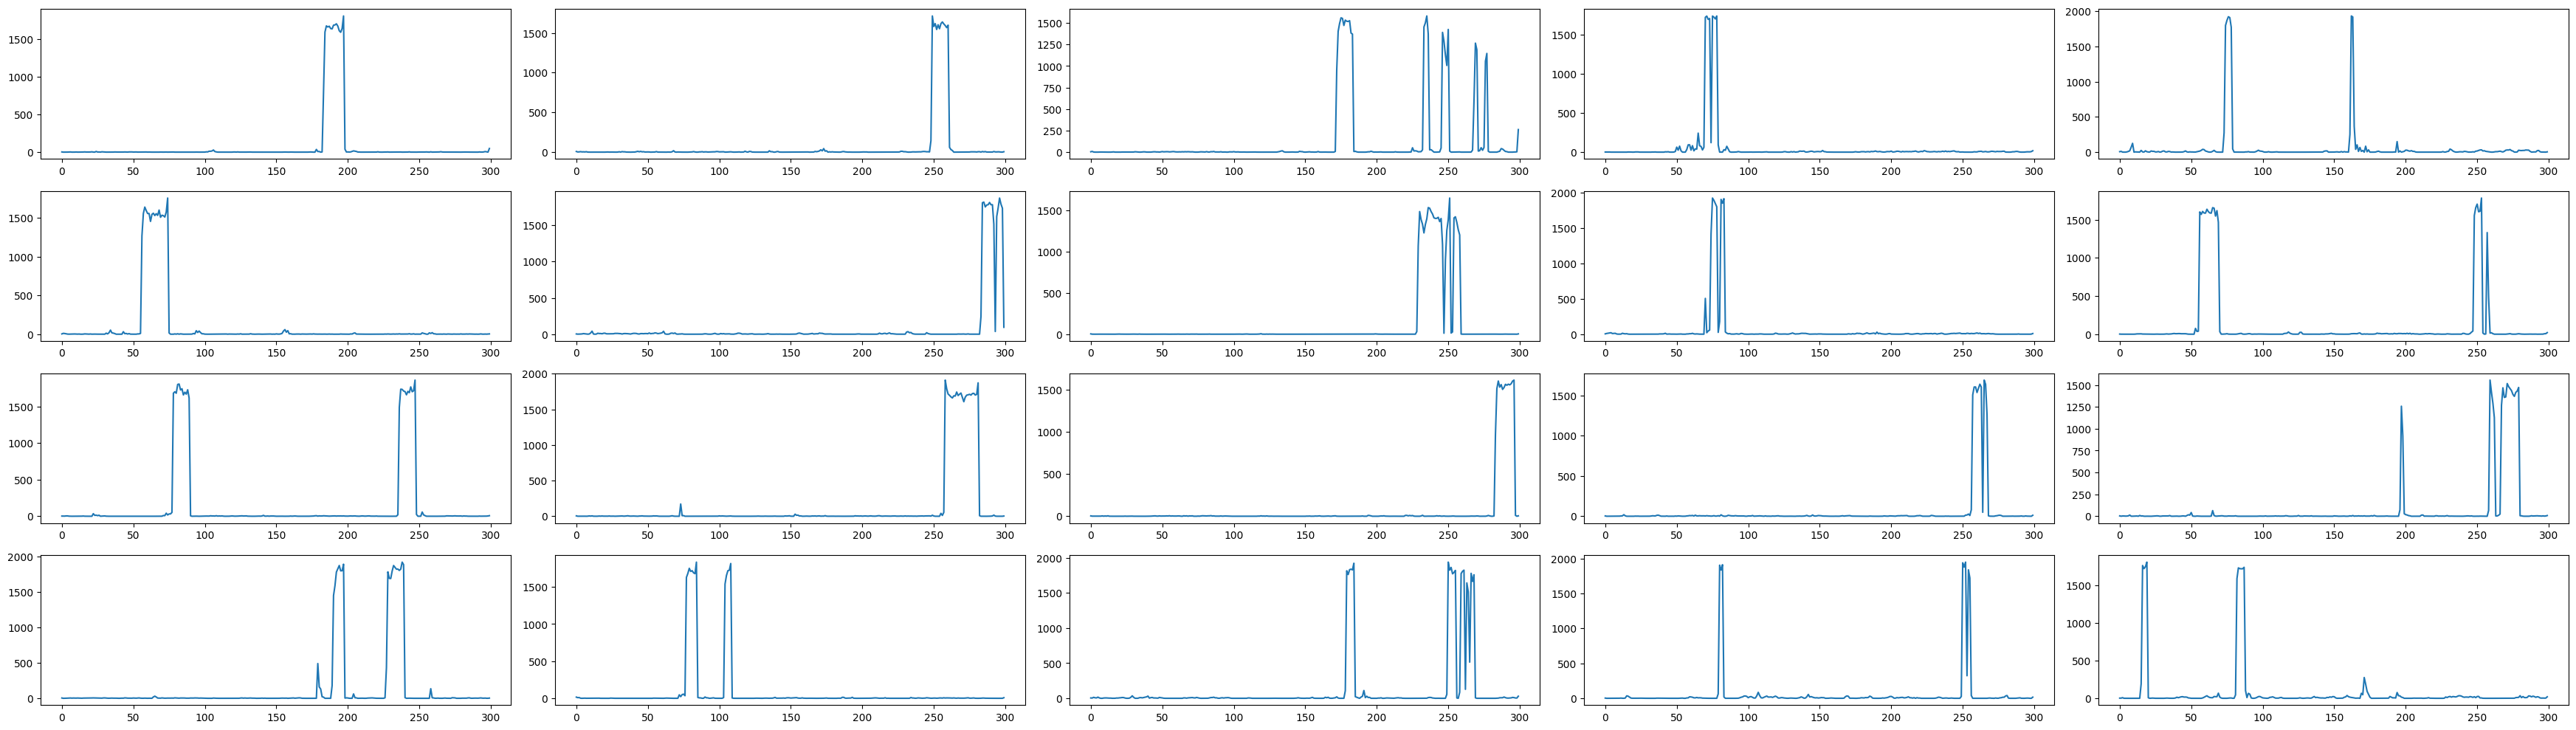

In [32]:
non_noisy_synthetic = [signal for signal in synthetic_data if (count_fluctuations(signal) < 7 and count_fluctuations(signal) >= 2) ]
non_noisy_synthetic = [ signal for signal in non_noisy_synthetic if signal.max()> 1000]
plt.figure(figsize=(35,10))
plt.title("Synthetic Data Samples")
nb=20
for i , synthetic in enumerate(random.sample(non_noisy_synthetic,nb)):
    plt.subplot(nb//5,5,i+1)
    plt.plot(synthetic)
#     plt.title(f"{count_fluctuations(synthetic)}")

plt.tight_layout()

In [33]:
# Parameters
window_size = 300
device = "cpu"

# Identify active windows in the original data
active_windows = []
for i in range(0, len(X_all) - window_size + 1, window_size):
    if np.sum(y_all[i:i + window_size] > 700) >= 10:  
        active_windows.append(i)

print(f"Number of active windows: {len(active_windows)}")

# Generate synthetic data
synthetic_data = generate_synthetic_data(g_model.to(device), latent_dim, len(active_windows)*3, device)
synthetic_data = synthetic_data.squeeze(1)
synthetic_data = synthetic_data * MAX_y
print(synthetic_data.shape)
non_noisy_synthetic = [signal for signal in synthetic_data if (count_fluctuations(signal) < 7 and count_fluctuations(signal) >= 2) ]
non_noisy_synthetic = [ signal for signal in non_noisy_synthetic if signal.max()> 1000]
print(len(non_noisy_synthetic))

# Augment the dataset
X_all_augmented = X_all.copy()
y_all_augmented = y_all.copy()

for i, start_idx in enumerate(active_windows):
    if i < len(synthetic_data):  
        synthetic_window = non_noisy_synthetic[i]
        for j in range(window_size):
            # Subtract the old window values and add the synthetic window values
            X_all_augmented[start_idx + j] += synthetic_window[j] - y_all[start_idx + j]
            y_all_augmented[start_idx + j] += synthetic_window[j] - y_all[start_idx + j]


# Remove negative values
X_all_augmented = np.maximum(X_all_augmented, 0) 
y_all_augmented = np.maximum(y_all_augmented, 0) 

print(f"Augmented {len(active_windows)} active windows with synthetic samples.")


Number of active windows: 179
(537, 300)
294
Augmented 179 active windows with synthetic samples.


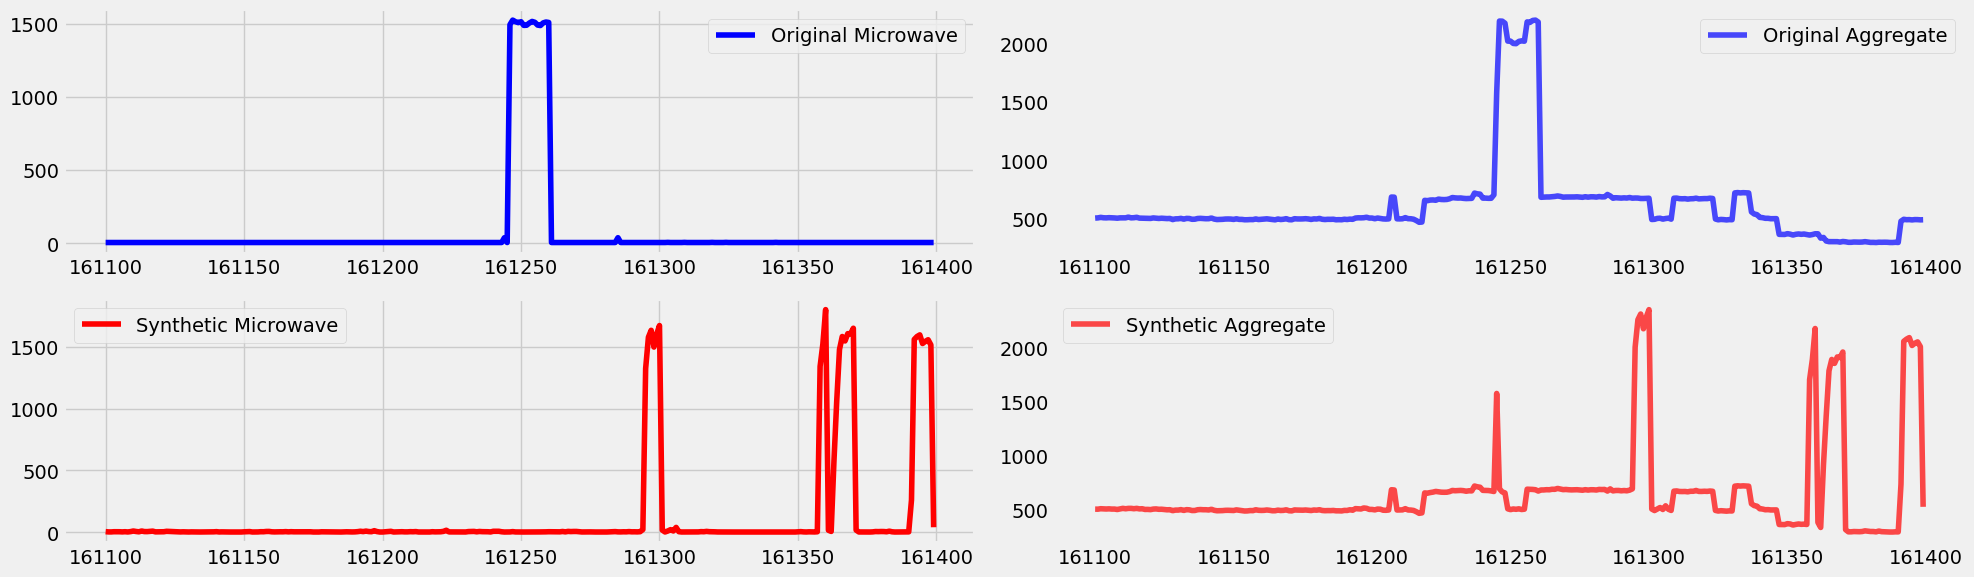

In [111]:
idx=random.randint(0,len(active_windows))

start_idx = active_windows[idx] 
end_idx = start_idx + window_size

original_x = X_all[start_idx:end_idx]
augmented_x = X_all_augmented[start_idx:end_idx]
original_y = y_all[start_idx:end_idx]
augmented_y = y_all_augmented[start_idx:end_idx]

plt.figure(figsize=(20, 6))

plt.subplot(2, 2, 1)
plt.plot(np.arange(start_idx, end_idx), original_y, label="Original Microwave", color="blue")
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(np.arange(start_idx, end_idx), original_x, label="Original Aggregate", color="blue", alpha=0.7)
plt.legend()
plt.grid()

# Plot original vs. augmented for y_all
plt.subplot(2, 2, 3)
plt.plot(np.arange(start_idx, end_idx), augmented_y, label="Synthetic Microwave", color="red")
plt.legend()
plt.subplot(2, 2, 4)
plt.plot(np.arange(start_idx, end_idx), augmented_x, label="Synthetic Aggregate", color="red", alpha=0.7)
plt.legend()
plt.grid()


plt.tight_layout()
plt.show()

612843


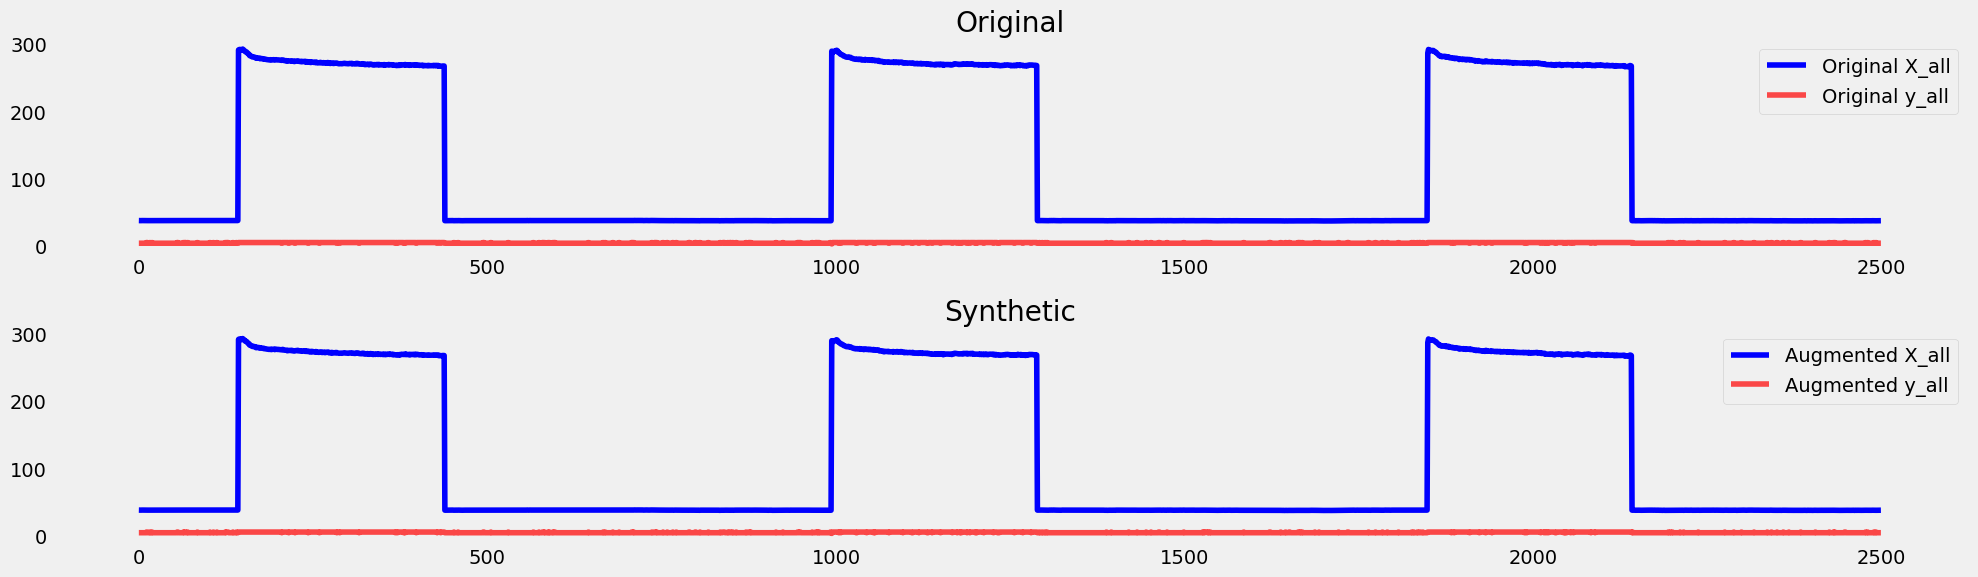

In [83]:
# Original and augmented signals
original_x = X_all
augmented_x = X_all_augmented
original_y = y_all
augmented_y = y_all_augmented
idx=random.randint(0,len(X_all)-5000)
print(idx)
# Plot original vs. augmented for X_all
plt.figure(figsize=(20, 6))
plt.subplot(2, 1, 1)
plt.plot(original_x[idx:idx+2500], label="Original X_all", color="blue")
plt.plot(original_y[idx:idx+2500], label="Original y_all", color="red", alpha=0.7)
plt.title("Original")
plt.legend()
plt.grid()

# Plot original vs. augmented for y_all
plt.subplot(2, 1, 2)
plt.plot(augmented_x[idx:idx+2500], label="Augmented X_all", color="blue")
plt.plot(augmented_y[idx:idx+2500], label="Augmented y_all", color="red", alpha=0.7)
plt.title("Synthetic")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
# from sklearn.model_selection import train_test_split


# X_train_aug, X_temp, y_train_aug, y_temp = train_test_split(X_all_augmented, y_all_augmented, test_size=0.3)
# X_test_aug, X_val_aug, y_test_aug, y_val_aug = train_test_split(X_temp, y_temp, test_size=0.5)

# print('Augmented training set size = {}'.format(X_train_aug.shape))
# print('===============================')
# print('Augmented test set size {}'.format(X_test_aug.shape))
# print('===============================')
# print('Augmented validation set size {}'.format(X_val_aug.shape))


In [41]:
MAX_X = 3000
MAX_y = 2000
windows_length = 100

X_aug_final=np.concatenate([X_all,X_all_augmented])
y_aug_final=np.concatenate([y_all,y_all_augmented])

print('TRAINING')
X_o, y_o = get_odd_data(X_aug_final, y_aug_final, MAX_X, MAX_y)
X_train_seg_aug, y_train_seg_aug  = shift_segment(X_o,y_o,windows_length,stride)
print(X_train_seg_aug.shape, y_train_seg_aug.shape)
print('===============================')

# print('TEST')
# X_o, y_o = get_odd_data(X_test_aug, y_test_aug, MAX_X, MAX_y)
# X_test_seg_aug, y_test_seg_aug  = shift_segment(X_o,y_o,windows_length,stride)
# print(X_test_seg_aug.shape, y_test_seg_aug.shape)
# print('===============================')

# print('VALIDATION')
# X_o, y_o = get_odd_data(X_val_aug, y_val_aug, MAX_X, MAX_y)
# X_val_seg_aug, y_val_seg_aug  = shift_segment(X_o,y_o,windows_length,stride)
# print(X_val_seg_aug.shape, y_val_seg_aug.shape)
    

TRAINING
        sequence length = 2199441
        windows length = 100
        stride = 1
        segments = 2199342
(2199342, 100) (2199342,)


In [42]:
appliance='microwave'
aug_model = create_model(windows_length)
aug_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 100, 16)   │         80 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 100, 16)   │         64 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 100, 32)   │      2,080 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 32)   │        128 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 100, 64)   │      8,256 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 64)   │        256 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 100, 128)  │     49,920 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 100, 128)  │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 100, 128)  │     74,496 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 100, 128)  │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 100, 64)   │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 100, 64)   │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 100, 64)   │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 100, 64)   │          0 │ dense[0][0],      │
│ (Attention)         │                   │            │ dense_1[0][0],    │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 100, 128)  │      8,320 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 100, 128)  │          0 │ dropout_1[0][0],  │
│                     │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 100, 128)  │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 12800)     │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │  1,638,528 │ flatten[0][0]   

 Total params: 1,807,281 (6.89 MB)

 Trainable params: 1,807,057 (6.89 MB)

 Non-trainable params: 224 (896.00 B)

In [45]:
ckpt = ModelCheckpoint(filepath=f"/kaggle/working/best_GRU_{appliance}_aug.keras", verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=3, verbose=1, min_lr=0.000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, min_delta=0.000005, mode='min', verbose=1)

start=time.time()
history = aug_model.fit(
    X_train_seg_aug, 
    y_train_seg_aug, 
    epochs=30,
    batch_size=128, 
    validation_split= 0.25,
    callbacks=[ckpt, reduce_lr, early_stopping]
)
end=time.time()
print('Execution time : ', end - start , ' sec')
aug_model = load_model(f"/kaggle/working/best_GRU_{appliance}_aug.keras")

Epoch 1/30
12887/12887 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0026 - mae: 0.0080
Epoch 1: val_loss improved from inf to 0.00163, saving model to /kaggle/working/best_GRU_microwave_aug.keras
12887/12887 ━━━━━━━━━━━━━━━━━━━━ 433s 34ms/step - loss: 0.0026 - mae: 0.0080 - val_loss: 0.0016 - val_mae: 0.0066 - learning_rate: 1.0000e-04
Epoch 2/30
12887/12887 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0015 - mae: 0.0052
Epoch 2: val_loss improved from 0.00163 to 0.00072, saving model to /kaggle/working/best_GRU_microwave_aug.keras
12887/12887 ━━━━━━━━━━━━━━━━━━━━ 436s 34ms/step - loss: 0.0015 - mae: 0.0052 - val_loss: 7.2297e-04 - val_mae: 0.0039 - learning_rate: 1.0000e-04
Epoch 3/30
12887/12887 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0012 - mae: 0.0046
Epoch 3: val_loss improved from 0.00072 to 0.00072, saving model to /kaggle/working/best_GRU_microwave_aug.keras
12887/12887 ━━━━━━━━━━━━━━━━━━━━ 436s 34ms/step - loss: 0.0012 - mae: 0.0046 - val_loss: 7.2212e-04 - val_mae: 0.0041 -

## Visualising model performance 

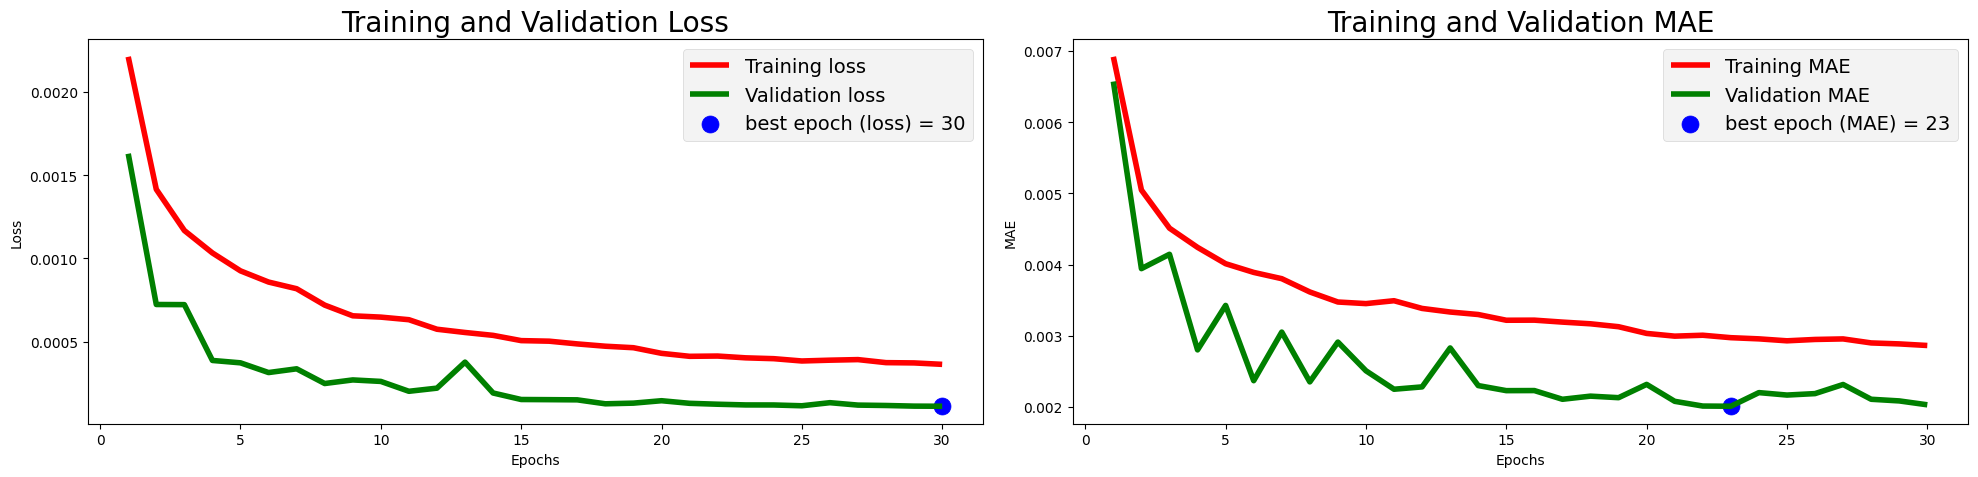

In [46]:
tr_loss = history.history['loss']
val_loss = history.history['val_loss']
tr_mae = history.history['mae']
val_mae = history.history['val_mae']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_mae = np.argmin(val_mae)
mae_lowest = val_mae[index_mae]

Epochs = [i + 1 for i in range(len(tr_loss))]
loss_label = f'best epoch (loss) = {str(index_loss + 1)}'
mae_label = f'best epoch (MAE) = {str(index_mae + 1)}'

fig, axes = plt.subplots(1, 2, figsize=(20, 5))
plt.style.use('fivethirtyeight')

# Plot losses
axes[0].plot(Epochs, tr_loss, 'r', label='Training loss')
axes[0].plot(Epochs, val_loss, 'g', label='Validation loss')
axes[0].scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot MAE
axes[1].plot(Epochs, tr_mae, 'r', label='Training MAE')
axes[1].plot(Epochs, val_mae, 'g', label='Validation MAE')
axes[1].scatter(index_mae + 1, mae_lowest, s=150, c='blue', label=mae_label)
axes[1].set_title('Training and Validation MAE')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('MAE')
axes[1].legend()

plt.tight_layout()
plt.show()
